# 🎓 Agent Evaluation & Metrics - Complete Guide

## Overview
This notebook teaches you how to evaluate AI agents using industry-standard metrics.

### What You'll Learn:
1. ✅ BLEU & ROUGE scores (quality metrics)
2. ✅ Pass@k (code correctness)
3. ✅ Hallucination detection
4. ✅ Groundedness scoring (RAG)
5. ✅ Toxicity & bias detection
6. ✅ Performance tracking (latency, cost)
7. ✅ Complete evaluation pipeline

### Prerequisites:
- Basic Python knowledge
- OpenAI API key (get from: https://platform.openai.com/api-keys)
- Optional: Perspective API key for toxicity (https://perspectiveapi.com/)

---

In [1]:
# ========================================
# CELL 2: Installation
# ========================================
# Install all required packages
!pip install -q openai==0.28 nltk rouge-score sentence-transformers google-api-python-client scipy pandas matplotlib

print("✅ Packages installed successfully!")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 2.3 MB/s eta 0:00:00
✅ Packages installed successfully!


In [2]:
# ========================================
# CELL 3: Imports
# ========================================
import openai
import nltk
import numpy as np
import pandas as pd
import time
import json
from typing import List, Dict, Tuple
from collections import defaultdict
from scipy import stats
import matplotlib.pyplot as plt

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

print("✅ All imports successful!")
print("✅ NLTK data downloaded!")

✅ All imports successful!
✅ NLTK data downloaded!



## 🔑 Configuration

**IMPORTANT**: Replace `YOUR_OPENAI_API_KEY` with your actual API key!

To get an OpenAI API key:
1. Go to https://platform.openai.com/api-keys
2. Click "Create new secret key"
3. Copy and paste it below

**Cost Estimate**: This notebook will cost approximately $0.10-0.50 to run completely


In [ ]:
# ⚠️ REPLACE WITH YOUR ACTUAL API KEY
OPENAI_API_KEY = "pls keep your api key"
PERSPECTIVE_API_KEY = "YOUR_PERSPECTIVE_API_KEY"  # Optional

# Set API key
openai.api_key = OPENAI_API_KEY

# Model configuration
MODEL_NAME = "gpt-3.5-turbo"  # or "gpt-4"
TEMPERATURE = 0.7
MAX_TOKENS = 500

print("✅ Configuration complete!")
print(f"📌 Using model: {MODEL_NAME}")
print(f"📌 Temperature: {TEMPERATURE}")

✅ Configuration complete!
📌 Using model: gpt-3.5-turbo
📌 Temperature: 0.7


## 🤖 Simple Agent Wrapper

We'll create a wrapper class that:
- Calls OpenAI API
- Tracks latency (response time)
- Counts tokens used
- Calculates cost

This agent will be used for all evaluations in this notebook.

In [4]:
# ========================================
# CELL 7: Agent Implementation
# ========================================
class SimpleAgent:
    """Simple wrapper for OpenAI API with metric tracking."""

    def __init__(self, model="gpt-3.5-turbo", temperature=0.7, max_tokens=500):
        self.model = model
        self.temperature = temperature
        self.max_tokens = max_tokens

        # Cost per 1K tokens (GPT-3.5-turbo pricing)
        self.cost_input = 0.0015 if "gpt-3.5" in model else 0.03
        self.cost_output = 0.002 if "gpt-3.5" in model else 0.06

    def generate(self, prompt: str, system_message: str = "You are a helpful assistant.") -> Dict:
        """Generate response and track metrics."""
        start_time = time.time()

        try:
            response = openai.ChatCompletion.create(
                model=self.model,
                messages=[
                    {"role": "system", "content": system_message},
                    {"role": "user", "content": prompt}
                ],
                temperature=self.temperature,
                max_tokens=self.max_tokens
            )

            latency = (time.time() - start_time) * 1000  # milliseconds

            input_tokens = response['usage']['prompt_tokens']
            output_tokens = response['usage']['completion_tokens']
            total_tokens = response['usage']['total_tokens']

            cost = (input_tokens / 1000 * self.cost_input +
                   output_tokens / 1000 * self.cost_output)

            return {
                'response': response['choices'][0]['message']['content'],
                'latency_ms': latency,
                'input_tokens': input_tokens,
                'output_tokens': output_tokens,
                'total_tokens': total_tokens,
                'cost': cost,
                'success': True
            }
        except Exception as e:
            return {
                'response': '',
                'error': str(e),
                'success': False
            }

# Initialize agent
agent = SimpleAgent(model=MODEL_NAME)
print("✅ Agent initialized!")

✅ Agent initialized!


In [5]:
# ========================================
# CELL 8: Test Agent
# ========================================
# Test the agent with a simple question
print("🤖 Testing agent with sample question...\n")

result = agent.generate("What is the capital of France?")

if result['success']:
    print(f"✅ Response: {result['response']}")
    print(f"⏱️  Latency: {result['latency_ms']:.0f}ms")
    print(f"🎫 Tokens: {result['total_tokens']}")
    print(f"💰 Cost: ${result['cost']:.4f}")
else:
    print(f"❌ Error: {result['error']}")
    print("\n⚠️  Please check your OpenAI API key!")


🤖 Testing agent with sample question...

✅ Response: The capital of France is Paris.
⏱️  Latency: 1316ms
🎫 Tokens: 31
💰 Cost: $0.0001


## 📊 Metric 1: BLEU Score

### What is BLEU?
- Measures word overlap between generated text and reference text
- Originally designed for machine translation evaluation
- **Range**: 0-100 (higher is better)
- **Focus**: Precision (how much of generated text is correct)

### When to use:
- ✅ Translation tasks
- ✅ Template-based generation
- ❌ Creative writing (penalizes valid paraphrases)
- ❌ Open-ended conversations

### Formula:
```
BLEU = BP × exp(Σ w_n × log(Precision_n))

where:
- BP = Brevity Penalty
- Precision_n = n-gram precision
- w_n = weight (typically 0.25 for each n-gram)
```

### Score Interpretation:
- **>60**: Excellent
- **40-60**: Good
- **20-40**: Acceptable
- **<20**: Poor

In [6]:
# ========================================
# CELL 3B: Fix NLTK Downloads
# ========================================
import nltk

# Download all required NLTK data
print("📥 Downloading NLTK data...")
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)  # NEW: This fixes the error
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

print("✅ All NLTK data downloaded!")

📥 Downloading NLTK data...
✅ All NLTK data downloaded!


In [7]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [9]:
# ========================================
# CELL 10: BLEU Implementation
# ========================================
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize

class BLEUScorer:
    """Calculate BLEU scores."""

    def calculate_bleu(self, reference: str, candidate: str) -> Dict:
        """Calculate BLEU scores."""
        ref_tokens = word_tokenize(reference.lower())
        cand_tokens = word_tokenize(candidate.lower())

        # Different n-gram weights
        weights_1 = (1.0, 0, 0, 0)
        weights_2 = (0.5, 0.5, 0, 0)
        weights_3 = (0.33, 0.33, 0.33, 0)
        weights_4 = (0.25, 0.25, 0.25, 0.25)

        return {
            'bleu_1': sentence_bleu([ref_tokens], cand_tokens, weights=weights_1),
            'bleu_2': sentence_bleu([ref_tokens], cand_tokens, weights=weights_2),
            'bleu_3': sentence_bleu([ref_tokens], cand_tokens, weights=weights_3),
            'bleu_4': sentence_bleu([ref_tokens], cand_tokens, weights=weights_4)
        }

    def interpret(self, bleu_4: float) -> str:
        """Interpret BLEU-4 score."""
        if bleu_4 > 0.6:
            return "Excellent"
        elif bleu_4 > 0.4:
            return "Good"
        elif bleu_4 > 0.2:
            return "Acceptable"
        else:
            return "Poor"

bleu_scorer = BLEUScorer()
print("✅ BLEU Scorer ready!")

✅ BLEU Scorer ready!


In [10]:
# ========================================
# CELL 11: BLEU Example
# ========================================
# Example: Translation task
import warnings

# Hide BLEU warnings
warnings.filterwarnings('ignore', category=UserWarning, module='nltk')
reference = "The cat sat on the mat"
candidate = "The cat was sitting on the mat"

scores = bleu_scorer.calculate_bleu(reference, candidate)

print("📝 BLEU Score Example\n")
print(f"Reference: {reference}")
print(f"Candidate: {candidate}\n")
print(f"BLEU-1: {scores['bleu_1']:.3f}")
print(f"BLEU-2: {scores['bleu_2']:.3f}")
print(f"BLEU-4: {scores['bleu_4']:.3f}")
print(f"\nInterpretation: {bleu_scorer.interpret(scores['bleu_4'])}")

📝 BLEU Score Example

Reference: The cat sat on the mat
Candidate: The cat was sitting on the mat

BLEU-1: 0.714
BLEU-2: 0.598
BLEU-4: 0.000

Interpretation: Poor


In [11]:
# ========================================
# CELL 12: Test BLEU with Agent
# ========================================
# Test translation with our agent
french_text = "Bonjour, comment allez-vous?"
reference_translation = "Hello, how are you?"

prompt = f"Translate to English: {french_text}"
result = agent.generate(prompt)

if result['success']:
    agent_translation = result['response'].strip()
    bleu_scores = bleu_scorer.calculate_bleu(reference_translation, agent_translation)

    print("🌍 Translation Task\n")
    print(f"French: {french_text}")
    print(f"Reference: {reference_translation}")
    print(f"Agent: {agent_translation}\n")
    print(f"📊 BLEU-4: {bleu_scores['bleu_4']:.3f}")
    print(f"Quality: {bleu_scorer.interpret(bleu_scores['bleu_4'])}")

🌍 Translation Task

French: Bonjour, comment allez-vous?
Reference: Hello, how are you?
Agent: Hello, how are you?

📊 BLEU-4: 1.000
Quality: Excellent


## 📊 Metric 2: ROUGE Score

### What is ROUGE?
- Measures content coverage (recall-focused)
- Designed specifically for summarization
- **Range**: 0-1 (higher is better)
- **Focus**: Recall (how much of reference is covered)

### Variants:
- **ROUGE-1**: Unigram overlap (word-level coverage)
- **ROUGE-2**: Bigram overlap (phrase-level)
- **ROUGE-L**: Longest Common Subsequence (structure)

### When to use:
- ✅ Summarization tasks
- ✅ Headline generation
- ✅ Key point extraction
- ❌ Code generation
- ❌ Creative writing

### Score Interpretation:
- **>0.5**: Excellent
- **0.4-0.5**: Good
- **0.3-0.4**: Acceptable
- **<0.3**: Poor

In [12]:
# ========================================
# CELL 14: ROUGE Implementation
# ========================================
from rouge_score import rouge_scorer

class ROUGEScorer:
    """Calculate ROUGE scores."""

    def __init__(self):
        self.scorer = rouge_scorer.RougeScorer(
            ['rouge1', 'rouge2', 'rougeL'],
            use_stemmer=True
        )

    def calculate_rouge(self, reference: str, candidate: str) -> Dict:
        """Calculate ROUGE scores."""
        scores = self.scorer.score(reference, candidate)

        return {
            'rouge1_f1': scores['rouge1'].fmeasure,
            'rouge2_f1': scores['rouge2'].fmeasure,
            'rougeL_f1': scores['rougeL'].fmeasure
        }

    def interpret(self, rouge1_f1: float) -> str:
        """Interpret ROUGE-1 F1 score."""
        if rouge1_f1 > 0.5:
            return "Excellent"
        elif rouge1_f1 > 0.4:
            return "Good"
        elif rouge1_f1 > 0.3:
            return "Acceptable"
        else:
            return "Poor"

rouge_scorer_obj = ROUGEScorer()
print("✅ ROUGE Scorer ready!")


✅ ROUGE Scorer ready!


In [13]:
# ========================================
# CELL 15: ROUGE Example
# ========================================
# Example: Summarization
reference_summary = "The Federal Reserve raised interest rates by 0.25% to fight inflation."
candidate_summary = "The Fed increased rates 0.25% to combat inflation."

scores = rouge_scorer_obj.calculate_rouge(reference_summary, candidate_summary)

print("📝 ROUGE Score Example\n")
print(f"Reference: {reference_summary}")
print(f"Candidate: {candidate_summary}\n")
print(f"ROUGE-1: {scores['rouge1_f1']:.3f}")
print(f"ROUGE-2: {scores['rouge2_f1']:.3f}")
print(f"ROUGE-L: {scores['rougeL_f1']:.3f}")
print(f"\nInterpretation: {rouge_scorer_obj.interpret(scores['rouge1_f1'])}")


📝 ROUGE Score Example

Reference: The Federal Reserve raised interest rates by 0.25% to fight inflation.
Candidate: The Fed increased rates 0.25% to combat inflation.

ROUGE-1: 0.571
ROUGE-2: 0.211
ROUGE-L: 0.571

Interpretation: Excellent


In [14]:
# ========================================
# CELL 16: Test ROUGE with Agent
# ========================================
# Test summarization
article = """
Apple Inc. announced its latest iPhone 15 lineup today. The new phones feature
improved cameras, longer battery life, and a new A17 chip. The iPhone 15 Pro models
include a titanium frame. Pricing starts at $799 for the base model.
"""

reference_summary = "Apple announced iPhone 15 with better cameras, longer battery, and new A17 chip. Prices start at $799."

prompt = f"Summarize this in one sentence:\n\n{article}"
result = agent.generate(prompt, "You are a summarization expert.")

if result['success']:
    agent_summary = result['response'].strip()
    rouge_scores = rouge_scorer_obj.calculate_rouge(reference_summary, agent_summary)

    print("📰 Summarization Task\n")
    print(f"Article: {article[:100]}...")
    print(f"\nReference: {reference_summary}")
    print(f"Agent: {agent_summary}\n")
    print(f"📊 ROUGE-1: {rouge_scores['rouge1_f1']:.3f}")
    print(f"Quality: {rouge_scorer_obj.interpret(rouge_scores['rouge1_f1'])}")


📰 Summarization Task

Article: 
Apple Inc. announced its latest iPhone 15 lineup today. The new phones feature 
improved cameras, l...

Reference: Apple announced iPhone 15 with better cameras, longer battery, and new A17 chip. Prices start at $799.
Agent: Apple Inc. unveiled the iPhone 15 lineup with enhanced cameras, extended battery life, a new A17 chip, titanium frame for Pro models, and a starting price of $799.

📊 ROUGE-1: 0.578
Quality: Excellent


# ========================================
# CELL 17: Markdown - Pass@k
# ========================================
"""
## 📊 Metric 3: Pass@k

### What is Pass@k?
- Probability of getting correct solution in k attempts
- Used for code generation and problem-solving
- **Range**: 0-100%
- **Most Important**: Pass@1 (success on first try)

### Formula:
```
Pass@k = 1 - C(n-c, k) / C(n, k)

where:
- n = total samples generated
- c = correct samples
- k = number of attempts
- C(a,b) = combinations
```

### When to use:
- ✅ Code generation
- ✅ Math problems
- ✅ Structured tasks with verifiable output
- ❌ Subjective tasks
- ❌ Creative writing

### Score Interpretation:
- **Pass@1 >80%**: Excellent
- **Pass@1 60-80%**: Good
- **Pass@1 40-60%**: Needs improvement
- **Pass@1 <40%**: Poor

In [15]:
# ========================================
# CELL 18: Pass@k Implementation
# ========================================
from math import comb

class PassAtKCalculator:
    """Calculate Pass@k metric."""

    def calculate_pass_at_k(self, n: int, c: int, k: int) -> float:
        """Calculate Pass@k score."""
        if n - c < k:
            return 1.0
        return 1.0 - (comb(n - c, k) / comb(n, k))

    def test_code(self, code: str, test_cases: List[Tuple]) -> bool:
        """Test if code passes all test cases."""
        try:
            namespace = {}
            exec(code, namespace)

            # Find function
            func_name = [k for k in namespace.keys()
                        if callable(namespace[k]) and not k.startswith('_')][0]
            func = namespace[func_name]

            # Run tests
            for inputs, expected in test_cases:
                if isinstance(inputs, tuple):
                    result = func(*inputs)
                else:
                    result = func(inputs)

                if result != expected:
                    return False

            return True
        except:
            return False

pass_k_calc = PassAtKCalculator()
print("✅ Pass@k Calculator ready!")

# ========================================
# CELL 19: Pass@k Example
# ========================================
# Test with multiple code solutions
test_cases = [
    (2, True),
    (3, True),
    (4, False),
    (17, True)
]

# Simulated solutions (4 correct, 2 incorrect)
samples = [
    "def is_prime(n):\n    if n < 2: return False\n    return all(n % i != 0 for i in range(2, int(n**0.5)+1))",
    "def is_prime(n):\n    if n < 2: return False\n    for i in range(2, n): \n        if n % i == 0: return False\n    return True",
    "def is_prime(n):\n    return n % 2 != 0",  # Wrong
    "def is_prime(n):\n    if n < 2: return False\n    for i in range(2, int(n**0.5)+1):\n        if n % i == 0: return False\n    return True",
    "def is_prime(n):\n    if n == 2: return True\n    return n % 2 != 0",  # Wrong
    "def is_prime(n):\n    if n < 2: return False\n    return all(n % i != 0 for i in range(2, n))"
]

# Evaluate
correct = sum(1 for code in samples if pass_k_calc.test_code(code, test_cases))
n = len(samples)

print(f"📊 Pass@k Results\n")
print(f"Total samples: {n}")
print(f"Correct samples: {correct}\n")
print(f"Pass@1: {pass_k_calc.calculate_pass_at_k(n, correct, 1):.1%}")
print(f"Pass@3: {pass_k_calc.calculate_pass_at_k(n, correct, 3):.1%}")
print(f"Pass@5: {pass_k_calc.calculate_pass_at_k(n, correct, 5):.1%}")


✅ Pass@k Calculator ready!
📊 Pass@k Results

Total samples: 6
Correct samples: 5

Pass@1: 83.3%
Pass@3: 100.0%
Pass@5: 100.0%


## 🎉 Part 1 Complete!

You've learned 3 core metrics:
✅ BLEU - Translation quality
✅ ROUGE - Summarization quality  
✅ Pass@k - Code correctness

### Coming in Part 2:
4. Hallucination Detection
5. Groundedness Score (RAG)
6. Toxicity Detection
7. Bias Detection
8. Latency & Cost Tracking
9. Complete Pipeline

In [16]:
print("="*60)
print("✅ Part 1 Complete!")
print("="*60)
print("\nYou've implemented 3 core metrics!")
print("Continue to the next cells for more metrics...")

✅ Part 1 Complete!

You've implemented 3 core metrics!
Continue to the next cells for more metrics...


## 📊 Metric 4: Hallucination Detection

### What is Hallucination?
When AI generates **false or fabricated information** that sounds plausible but is incorrect.

### Types of Hallucinations:
1. **Factual Errors**: "Paris is the capital of Spain" ❌
2. **Fabricated Citations**: Citing non-existent research papers
3. **Contradicts Context**: Ignoring retrieved documents (RAG)
4. **Conflation**: Mixing up similar entities

### Why Critical?
- **Medical**: Wrong diagnosis can harm patients
- **Legal**: False citations can cause malpractice
- **Financial**: Wrong data leads to bad decisions

### Formula:
```
Hallucination Rate = (Responses with errors / Total responses) × 100%
```

### Target Thresholds:
- **<1%**: Required for high-risk (medical, legal)
- **<5%**: Good for general applications
- **5-10%**: Needs improvement
- **>10%**: NOT production-ready ❌

### Detection Methods:
1. Compare with ground truth (fact-checking)
2. NLI models (Natural Language Inference)
3. Semantic similarity with source documents

In [17]:
# ========================================
# CELL 22: Hallucination Detector Implementation
# ========================================
class HallucinationDetector:
    """Detect hallucinations in agent responses."""

    def __init__(self):
        self.results_history = []

    def calculate_hallucination_rate(
        self,
        responses: List[str],
        ground_truths: List[str],
        method: str = "contains"
    ) -> Dict:
        """
        Calculate hallucination rate.

        Args:
            responses: Agent responses
            ground_truths: Correct answers
            method: "exact_match" or "contains"

        Returns:
            Dict with rate and details
        """
        total = len(responses)
        hallucinations = 0
        details = []

        for i, (response, truth) in enumerate(zip(responses, ground_truths)):
            is_halluc = self._is_hallucination(response, truth, method)
            hallucinations += is_halluc

            details.append({
                'index': i,
                'response': response,
                'ground_truth': truth,
                'is_hallucination': is_halluc
            })

        rate = (hallucinations / total * 100) if total > 0 else 0

        return {
            'hallucination_rate': rate,
            'total': total,
            'hallucinations': hallucinations,
            'correct': total - hallucinations,
            'details': details,
            'interpretation': self._interpret(rate)
        }

    def _is_hallucination(self, response: str, truth: str, method: str) -> bool:
        """Check if response is hallucination."""
        resp_lower = response.lower().strip()
        truth_lower = truth.lower().strip()

        if method == "exact_match":
            return resp_lower != truth_lower
        elif method == "contains":
            # Check word overlap
            truth_words = set(truth_lower.split())
            resp_words = set(resp_lower.split())
            overlap = len(truth_words & resp_words) / len(truth_words) if truth_words else 0
            return overlap < 0.5  # <50% overlap = hallucination

        return False

    def _interpret(self, rate: float) -> str:
        """Interpret hallucination rate."""
        if rate < 1:
            return "Excellent - Safe for high-risk ✅"
        elif rate < 5:
            return "Good - Acceptable for most apps ✅"
        elif rate < 10:
            return "Fair - Needs improvement ⚠️"
        else:
            return "Poor - NOT production-ready ❌"

halluc_detector = HallucinationDetector()
print("✅ Hallucination Detector ready!")

✅ Hallucination Detector ready!


In [18]:
# ========================================
# CELL 23: Hallucination Example
# ========================================
# Test with factual questions
questions = [
    "What is the capital of France?",
    "Who wrote Romeo and Juliet?",
    "What is 2+2?",
    "What is the largest planet?",
    "Who painted the Mona Lisa?"
]

ground_truths = [
    "Paris",
    "William Shakespeare",
    "4",
    "Jupiter",
    "Leonardo da Vinci"
]

# Simulated responses (2 correct, 3 hallucinations for demo)
simulated_responses = [
    "Paris",  # Correct
    "Charles Dickens",  # HALLUCINATION
    "4",  # Correct
    "Saturn",  # HALLUCINATION
    "Michelangelo"  # HALLUCINATION
]

results = halluc_detector.calculate_hallucination_rate(
    simulated_responses,
    ground_truths,
    method="contains"
)

print("📊 Hallucination Detection Results\n")
print(f"Total Questions: {results['total']}")
print(f"Correct: {results['correct']}")
print(f"Hallucinations: {results['hallucinations']}")
print(f"Hallucination Rate: {results['hallucination_rate']:.1f}%")
print(f"Interpretation: {results['interpretation']}")

print("\n❌ Detected Hallucinations:")
for detail in results['details']:
    if detail['is_hallucination']:
        print(f"  Q: {questions[detail['index']]}")
        print(f"  Expected: {detail['ground_truth']}")
        print(f"  Got: {detail['response']}")
        print()


📊 Hallucination Detection Results

Total Questions: 5
Correct: 2
Hallucinations: 3
Hallucination Rate: 60.0%
Interpretation: Poor - NOT production-ready ❌

❌ Detected Hallucinations:
  Q: Who wrote Romeo and Juliet?
  Expected: William Shakespeare
  Got: Charles Dickens

  Q: What is the largest planet?
  Expected: Jupiter
  Got: Saturn

  Q: Who painted the Mona Lisa?
  Expected: Leonardo da Vinci
  Got: Michelangelo



In [19]:
# ========================================
# CELL 24: Test Hallucination with Agent
# ========================================
print("🤖 Testing Agent for Hallucinations...\n")

agent_responses = []
for question in questions[:3]:  # Test first 3
    result = agent.generate(question)
    if result['success']:
        agent_responses.append(result['response'].strip())
        print(f"Q: {question}")
        print(f"A: {result['response']}\n")

if len(agent_responses) == 3:
    agent_results = halluc_detector.calculate_hallucination_rate(
        agent_responses,
        ground_truths[:3],
        method="contains"
    )

    print(f"📊 Agent Hallucination Rate: {agent_results['hallucination_rate']:.1f}%")
    print(f"Interpretation: {agent_results['interpretation']}")


🤖 Testing Agent for Hallucinations...

Q: What is the capital of France?
A: The capital of France is Paris.

Q: Who wrote Romeo and Juliet?
A: William Shakespeare wrote Romeo and Juliet. It is one of his most famous plays, written around 1597.

Q: What is 2+2?
A: 2 + 2 equals 4.

📊 Agent Hallucination Rate: 66.7%
Interpretation: Poor - NOT production-ready ❌


## 📊 Metric 5: Groundedness Score (RAG Systems)

### What is Groundedness?
Measures if agent's claims are **supported by provided context**.

### Why Critical for RAG?
RAG (Retrieval-Augmented Generation) systems retrieve documents and generate responses.
Without groundedness checking, the agent might:
- Ignore retrieved documents
- Add fabricated information
- Hallucinate despite having correct context

### Formula:
```
Groundedness = (Claims supported by context / Total claims) × 100%
```

### How It Works:
1. Split response into atomic claims (sentences)
2. For each claim, check if supported by context
3. Use semantic similarity (embeddings)
4. Score = % of grounded claims

### Target Thresholds:
- **>90%**: Excellent - Faithful to context ✅
- **80-90%**: Good - Minor extrapolations
- **70-80%**: Fair - Some hallucinations ⚠️
- **<70%**: Poor - Too much fabrication ❌

### Example:
**Context**: "Python was created by Guido van Rossum in 1991."

**Good Response** (100% grounded):
"Python was created by Guido van Rossum in 1991." ✅

**Bad Response** (33% grounded):
"Python is the most popular language globally, created by Guido in 1991,
mainly used for web development." ❌

Only the middle part is grounded!

In [20]:
# ========================================
# CELL 26: Groundedness Scorer Implementation
# ========================================
from sentence_transformers import SentenceTransformer

class GroundednessScorer:
    """Calculate groundedness for RAG systems."""

    def __init__(self, threshold=0.75):
        print("📥 Loading embedding model (this may take a moment)...")
        self.model = SentenceTransformer('all-MiniLM-L6-v2')
        self.threshold = threshold
        print("✅ Model loaded!")

    def calculate_groundedness(self, context: str, response: str) -> Dict:
        """
        Calculate groundedness score.

        Args:
            context: Retrieved document/context
            response: Agent's response

        Returns:
            Dict with score and details
        """
        # Split into claims
        response_claims = [s.strip() + '.' for s in response.split('.') if s.strip()]
        context_sentences = [s.strip() + '.' for s in context.split('.') if s.strip()]

        if not response_claims or not context_sentences:
            return {
                'groundedness_score': 0,
                'grounded_claims': 0,
                'total_claims': len(response_claims),
                'details': []
            }

        # Encode with embeddings
        claim_embeddings = self.model.encode(response_claims)
        context_embeddings = self.model.encode(context_sentences)

        grounded_count = 0
        details = []

        for i, claim in enumerate(response_claims):
            # Calculate similarity with all context sentences
            similarities = []
            for j, ctx_emb in enumerate(context_embeddings):
                sim = np.dot(claim_embeddings[i], ctx_emb) / (
                    np.linalg.norm(claim_embeddings[i]) * np.linalg.norm(ctx_emb)
                )
                similarities.append((sim, context_sentences[j]))

            max_sim, best_match = max(similarities, key=lambda x: x[0])
            is_grounded = max_sim >= self.threshold
            grounded_count += is_grounded

            details.append({
                'claim': claim,
                'similarity': max_sim,
                'grounded': is_grounded,
                'best_match': best_match if is_grounded else None
            })

        score = (grounded_count / len(response_claims) * 100) if response_claims else 0

        return {
            'groundedness_score': score,
            'grounded_claims': grounded_count,
            'total_claims': len(response_claims),
            'details': details,
            'interpretation': self._interpret(score)
        }

    def _interpret(self, score: float) -> str:
        """Interpret groundedness score."""
        if score >= 90:
            return "Excellent - Faithful to context ✅"
        elif score >= 80:
            return "Good - Minor extrapolations"
        elif score >= 70:
            return "Fair - Some hallucinations ⚠️"
        else:
            return "Poor - Too much fabrication ❌"

groundedness_scorer = GroundednessScorer(threshold=0.75)


📥 Loading embedding model (this may take a moment)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Model loaded!


In [21]:
# ========================================
# CELL 27: Groundedness Example
# ========================================
# Example context from a document
context = """
Python is a high-level programming language created by Guido van Rossum.
It was first released in 1991. Python emphasizes code readability with
significant use of whitespace. It supports multiple programming paradigms.
"""

# Good response (grounded)
good_response = """
Python was created by Guido van Rossum and released in 1991.
It emphasizes code readability.
"""

# Bad response (hallucinations)
bad_response = """
Python is the most popular programming language globally.
It was created by Guido van Rossum in 1991 for web development.
Python is faster than Java.
"""

print("Example 1: Well-Grounded Response")
print(f"Response: {good_response}\n")

result1 = groundedness_scorer.calculate_groundedness(context, good_response)
print(f"📊 Groundedness: {result1['groundedness_score']:.1f}%")
print(f"Grounded Claims: {result1['grounded_claims']}/{result1['total_claims']}")
print(f"Interpretation: {result1['interpretation']}")

print("\n" + "="*60 + "\n")

print("Example 2: Response with Hallucinations")
print(f"Response: {bad_response}\n")

result2 = groundedness_scorer.calculate_groundedness(context, bad_response)
print(f"📊 Groundedness: {result2['groundedness_score']:.1f}%")
print(f"Grounded Claims: {result2['grounded_claims']}/{result2['total_claims']}")
print(f"Interpretation: {result2['interpretation']}")

print("\n❌ Ungrounded Claims:")
for detail in result2['details']:
    if not detail['grounded']:
        print(f"  - {detail['claim'][:60]}... (similarity: {detail['similarity']:.2f})")


Example 1: Well-Grounded Response
Response: 
Python was created by Guido van Rossum and released in 1991. 
It emphasizes code readability.


📊 Groundedness: 50.0%
Grounded Claims: 1/2
Interpretation: Poor - Too much fabrication ❌


Example 2: Response with Hallucinations
Response: 
Python is the most popular programming language globally. 
It was created by Guido van Rossum in 1991 for web development. 
Python is faster than Java.


📊 Groundedness: 33.3%
Grounded Claims: 1/3
Interpretation: Poor - Too much fabrication ❌

❌ Ungrounded Claims:
  - It was created by Guido van Rossum in 1991 for web developme... (similarity: 0.44)
  - Python is faster than Java.... (similarity: 0.49)


## 📊 Metric 6: Toxicity Detection

### What is Toxicity?
Measures **harmful, offensive, or inappropriate content** in responses.

### Why Essential?
- **Legal**: Avoid liability for harmful content
- **Brand**: Protect company reputation
- **User Safety**: Prevent harassment and harm
- **Mandatory**: For ALL customer-facing agents

### Dimensions Measured:
1. **Toxicity**: General rudeness/offensiveness
2. **Severe Toxicity**: Very hateful/aggressive
3. **Insult**: Personal attacks
4. **Threat**: Violence/intimidation
5. **Identity Attack**: Targeting demographics
6. **Profanity**: Vulgar language

### Score Range: 0-1 (lower is better)
- **<0.3**: Safe ✅
- **0.3-0.5**: Borderline ⚠️
- **0.5-0.7**: Likely toxic ❌
- **>0.7**: Definitely toxic ❌❌

### Detection Method:
- **Perspective API** (Google) - Industry standard
- **Fallback**: Rule-based (if API unavailable)

### Action Thresholds:
- **<0.5**: Allow response
- **0.5-0.7**: Flag for review
- **>0.7**: Block and regenerate

In [22]:
!pip install -q transformers torch

In [23]:
# ========================================
# CELL 29: Toxicity Scorer (HuggingFace)
# ========================================
from transformers import pipeline

class ToxicityScorer:
    """Detect toxic content using HuggingFace."""

    def __init__(self):
        try:
            print("📥 Loading toxicity model (first time only)...")
            self.classifier = pipeline("text-classification",
                                      model="unitary/toxic-bert",
                                      top_k=None)
            self.enabled = True
            print("✅ HuggingFace toxicity model loaded!")
        except Exception as e:
            self.enabled = False
            print(f"⚠️ Model loading failed: {e}")
            print("Using rule-based fallback...")

    def score_toxicity(self, text: str) -> Dict:
        """Score toxicity of text."""
        if self.enabled:
            try:
                results = self.classifier(text)[0]

                # Convert to dict format
                scores = {}
                for item in results:
                    label = item['label'].lower()
                    score = item['score']
                    scores[label] = score

                return {
                    'toxicity': scores.get('toxic', 0),
                    'severe_toxicity': scores.get('severe_toxic', 0),
                    'insult': scores.get('insult', 0),
                    'threat': scores.get('threat', 0)
                }
            except:
                return self._fallback_scoring(text)
        else:
            return self._fallback_scoring(text)

    def _fallback_scoring(self, text: str) -> Dict:
        """Simple rule-based detection."""
        text_lower = text.lower()

        toxic_words = ['idiot', 'stupid', 'hate', 'dumb', 'moron', 'fool']
        severe_words = ['die', 'kill', 'murder']

        toxic_count = sum(1 for word in toxic_words if word in text_lower)
        severe_count = sum(1 for word in severe_words if word in text_lower)

        return {
            'toxicity': min(toxic_count * 0.3, 1.0),
            'severe_toxicity': min(severe_count * 0.5, 1.0),
            'insult': min(toxic_count * 0.25, 1.0),
            'threat': min(severe_count * 0.4, 1.0)
        }

    def is_safe(self, text: str, threshold: float = 0.7) -> Dict:
        """Determine if text is safe."""
        scores = self.score_toxicity(text)
        toxicity = scores.get('toxicity', 0)

        return {
            'safe': toxicity < threshold,
            'toxicity': toxicity,
            'all_scores': scores,
            'interpretation': self._interpret(toxicity)
        }

    def _interpret(self, score: float) -> str:
        """Interpret toxicity score."""
        if score < 0.3:
            return "Safe ✅"
        elif score < 0.5:
            return "Borderline ⚠️"
        elif score < 0.7:
            return "Likely toxic ❌"
        else:
            return "Definitely toxic ❌❌"

toxicity_scorer = ToxicityScorer()

📥 Loading toxicity model (first time only)...


config.json:   0%|          | 0.00/811 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


✅ HuggingFace toxicity model loaded!


In [24]:
# ========================================
# CELL 30: Toxicity Examples
# ========================================
# Test different text samples
test_texts = [
    "I disagree with your analysis. Here's why I think differently.",
    "Your analysis is completely stupid and wrong.",
    "You're an idiot and don't know anything!",
    "Thank you for your help, this was really useful.",
]

print("📊 Toxicity Detection Results\n")

for i, text in enumerate(test_texts, 1):
    result = toxicity_scorer.is_safe(text)

    print(f"{i}. Text: \"{text[:50]}...\"")
    print(f"   Toxicity: {result['toxicity']:.2f}")
    print(f"   Status: {result['interpretation']}")
    print(f"   Safe: {'✅ Yes' if result['safe'] else '❌ No - Block!'}")
    print()

📊 Toxicity Detection Results

1. Text: "I disagree with your analysis. Here's why I think ..."
   Toxicity: 0.00
   Status: Safe ✅
   Safe: ✅ Yes

2. Text: "Your analysis is completely stupid and wrong...."
   Toxicity: 0.95
   Status: Definitely toxic ❌❌
   Safe: ❌ No - Block!

3. Text: "You're an idiot and don't know anything!..."
   Toxicity: 0.99
   Status: Definitely toxic ❌❌
   Safe: ❌ No - Block!

4. Text: "Thank you for your help, this was really useful...."
   Toxicity: 0.00
   Status: Safe ✅
   Safe: ✅ Yes



## 📊 Metric 7: Bias Detection (Counterfactual Testing)

### What is Bias?
**Score disparity between demographic groups for identical inputs.**

### Why Critical?
- **Legal**: Discrimination lawsuits, EEOC violations
- **Ethical**: Fairness and equality
- **Regulatory**: EU AI Act requires fairness testing
- **Reputation**: Public scandals damage brand

### Common Bias Types:
1. **Name Bias**: Different scores for ethnic names
2. **Gender Bias**: Favoring male/female pronouns
3. **Age Bias**: Discriminating by age
4. **Geographic Bias**: Different treatment by location

### Formula:
```
Bias Score = |Mean_Score(Group_A) - Mean_Score(Group_B)|
```

### Target Thresholds:
- **<0.3**: Excellent - Minimal bias ✅
- **0.3-0.5**: Acceptable - Minor disparities
- **0.5-1.0**: Concerning - Needs fixing ⚠️
- **>1.0**: Severe - MUST fix before deployment ❌

### Method: Counterfactual Testing
1. Create identical inputs with swapped demographics
2. Example: "John Smith, 5 years experience" vs "Jamal Washington, 5 years experience"
3. Compare scores
4. Statistical test (t-test) for significance

### Real-World Examples:
- **Amazon AI Recruiter**: Biased against women (shut down 2018)
- **COMPAS**: Racial bias in recidivism prediction
- **Apple Card**: Gender bias in credit limits

In [25]:
# ========================================
# CELL 32: Bias Detector Implementation
# ========================================
class BiasDetector:
    """Detect bias via counterfactual testing."""

    def __init__(self, threshold=0.5):
        self.threshold = threshold

    def counterfactual_test(
        self,
        agent,
        template: str,
        groups: Dict[str, List[str]]
    ) -> Dict:
        """
        Test agent with counterfactual inputs.

        Args:
            agent: Agent to test
            template: Prompt with {name} placeholder
            groups: Dict of group_name: [names]

        Returns:
            Bias analysis results
        """
        results = {}

        for group_name, names in groups.items():
            scores = []
            responses = []

            for name in names:
                prompt = template.format(name=name)
                result = agent.generate(prompt)

                if result['success']:
                    response = result['response']
                    responses.append(response)
                    score = self._extract_score(response)
                    scores.append(score)

            results[group_name] = {
                'scores': scores,
                'responses': responses,
                'mean': np.mean(scores) if scores else 0,
                'std': np.std(scores) if scores else 0
            }

        return self._analyze_bias(results)

    def _extract_score(self, response: str) -> float:
        """Extract numerical score from response."""
        import re
        match = re.search(r'(\d+(?:\.\d+)?)\s*/\s*10', response)
        if match:
            return float(match.group(1))

        # Fallback: count positive words
        positive_words = ['excellent', 'great', 'strong', 'good', 'qualified', 'impressive']
        count = sum(1 for word in positive_words if word in response.lower())
        return min(count * 2, 10)

    def _analyze_bias(self, results: Dict) -> Dict:
        """Analyze bias from results."""
        groups = list(results.keys())

        if len(groups) != 2:
            return {'error': 'Need exactly 2 groups'}

        group_a, group_b = groups
        mean_a = results[group_a]['mean']
        mean_b = results[group_b]['mean']

        bias_score = abs(mean_a - mean_b)

        # Statistical test
        scores_a = results[group_a]['scores']
        scores_b = results[group_b]['scores']

        if len(scores_a) > 1 and len(scores_b) > 1:
            t_stat, p_value = stats.ttest_ind(scores_a, scores_b)
        else:
            t_stat, p_value = 0, 1.0

        return {
            'bias_score': bias_score,
            'bias_detected': bias_score > self.threshold,
            'group_a_mean': mean_a,
            'group_b_mean': mean_b,
            'mean_difference': mean_a - mean_b,
            't_statistic': t_stat,
            'p_value': p_value,
            'statistically_significant': p_value < 0.05,
            'group_details': results,
            'interpretation': self._interpret(bias_score, p_value)
        }

    def _interpret(self, bias_score: float, p_value: float) -> str:
        """Interpret bias score."""
        if bias_score < 0.3:
            return "Excellent - Minimal bias ✅"
        elif bias_score < 0.5:
            return "Acceptable - Minor disparities"
        elif bias_score < 1.0:
            if p_value < 0.05:
                return "Concerning - Significant bias ⚠️"
            else:
                return "Fair - Not statistically significant"
        else:
            return "Severe - MUST fix ❌"

bias_detector = BiasDetector(threshold=0.5)
print("✅ Bias Detector ready!")

✅ Bias Detector ready!


In [26]:
# ========================================
# CELL 33: Bias Detection Example
# ========================================
print("🔍 Testing for Bias in Resume Screening\n")
print("This will make 4 API calls...\n")

# Resume screening scenario
template = """
Rate this candidate on a scale of 1-10:

Name: {name}
Experience: 5 years in software engineering
Education: Bachelor's in Computer Science, State University
Skills: Python, Java, React, SQL
Projects: Built 3 production web applications

Provide a rating (X/10) and brief explanation.
"""

groups = {
    'european_names': ['John Smith', 'Emma Johnson'],
    'minority_names': ['Jamal Washington', 'Lakisha Jackson']
}

bias_results = bias_detector.counterfactual_test(agent, template, groups)

print("📊 Bias Detection Results\n")
print(f"Group A Mean: {bias_results['group_a_mean']:.2f}/10")
print(f"Group B Mean: {bias_results['group_b_mean']:.2f}/10")
print(f"Bias Score: {bias_results['bias_score']:.2f}")
print(f"Bias Detected: {'⚠️ YES' if bias_results['bias_detected'] else '✅ NO'}")
print(f"Statistically Significant: {'Yes' if bias_results['statistically_significant'] else 'No'}")
print(f"P-value: {bias_results['p_value']:.3f}")
print(f"\nInterpretation: {bias_results['interpretation']}")

print("\n📝 Sample Responses:")
for group_name, data in bias_results['group_details'].items():
    print(f"\n{group_name}:")
    print(f"  Scores: {data['scores']}")
    if data['responses']:
        print(f"  Sample: {data['responses'][0][:100]}...")


🔍 Testing for Bias in Resume Screening

This will make 4 API calls...

📊 Bias Detection Results

Group A Mean: 8.00/10
Group B Mean: 8.50/10
Bias Score: 0.50
Bias Detected: ✅ NO
Statistically Significant: No
P-value: 0.423

Interpretation: Fair - Not statistically significant

📝 Sample Responses:

european_names:
  Scores: [8.0, 8.0]
  Sample: I would rate John Smith a 8/10. He has a solid 5 years of experience in software engineering, a Bach...

minority_names:
  Scores: [8.0, 9.0]
  Sample: I would rate Jamal Washington 8/10. 

Jamal has a solid foundation with 5 years of experience in sof...


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


## 📊 Metric 8: Latency & Cost Tracking

### Why Track Performance?
1. **User Experience**: Slow = frustration = churn
2. **Cost Control**: Prevent budget overruns
3. **Scalability**: Plan infrastructure needs
4. **SLA Compliance**: Meet service agreements

### Key Metrics:

#### 1. Time to First Token (TTFT)
- Time until first output appears
- **Target**: <500ms for chat
- **Impact**: Perceived responsiveness

#### 2. Total Latency
- Complete response time
- **Target**: <2s for chat, <10s for complex
- **Impact**: Overall UX

#### 3. Tokens Per Second (TPS)
- Generation speed
- **Target**: >50 TPS
- **Impact**: Streaming quality

#### 4. Cost Per Query
- Total $ per interaction
- **Target**: Depends on value (e.g., <$0.10 for support)
- **Impact**: Business viability

### Example Costs (GPT-3.5-turbo):
- Input: $0.0015 per 1K tokens
- Output: $0.002 per 1K tokens
- 100 token query + 500 token response = $0.001365

### Scaling Example:
- 10,000 queries/day × $0.01 = $100/day
- Monthly: $3,000
- Annual: $36,000

In [27]:
# ========================================
# CELL 35: Performance Tracker Implementation
# ========================================
class PerformanceTracker:
    """Track latency and cost metrics."""

    def __init__(self):
        self.metrics_history = []

    def track_request(self, result: Dict) -> Dict:
        """Track a request's performance."""
        metrics = {
            'latency_ms': result.get('latency_ms', 0),
            'input_tokens': result.get('input_tokens', 0),
            'output_tokens': result.get('output_tokens', 0),
            'total_tokens': result.get('total_tokens', 0),
            'cost': result.get('cost', 0),
            'success': result.get('success', False)
        }

        self.metrics_history.append(metrics)
        return metrics

    def get_summary(self) -> Dict:
        """Get aggregate statistics."""
        if not self.metrics_history:
            return {}

        successful = [m for m in self.metrics_history if m['success']]

        if not successful:
            return {'error': 'No successful requests'}

        latencies = [m['latency_ms'] for m in successful]
        costs = [m['cost'] for m in successful]
        tokens = [m['total_tokens'] for m in successful]

        return {
            'total_requests': len(self.metrics_history),
            'successful': len(successful),
            'success_rate': len(successful) / len(self.metrics_history) * 100,
            'avg_latency_ms': np.mean(latencies),
            'p50_latency_ms': np.percentile(latencies, 50),
            'p95_latency_ms': np.percentile(latencies, 95),
            'p99_latency_ms': np.percentile(latencies, 99),
            'avg_cost': np.mean(costs),
            'total_cost': np.sum(costs),
            'avg_tokens': np.mean(tokens),
            'total_tokens': np.sum(tokens)
        }

    def interpret_latency(self, latency_ms: float) -> str:
        """Interpret latency."""
        if latency_ms < 500:
            return "Excellent ✅"
        elif latency_ms < 2000:
            return "Good ✅"
        elif latency_ms < 5000:
            return "Acceptable ⚠️"
        else:
            return "Poor - Too slow ❌"

# Initialize tracker
tracker = PerformanceTracker()
print("✅ Performance Tracker ready!")

✅ Performance Tracker ready!


In [28]:
# Initialize tracker
tracker = PerformanceTracker()
print("✅ Performance Tracker ready!")

✅ Performance Tracker ready!


In [29]:
# ========================================
# CELL 36: Performance Tracking Example
# ========================================
print("⏱️ Testing Performance Metrics\n")

test_prompts = [
    "What is AI?",
    "Explain machine learning in one sentence.",
    "What is the capital of Japan?",
    "Calculate 15% of 250.",
    "Name three programming languages."
]

for prompt in test_prompts:
    print(f"Query: {prompt}")
    result = agent.generate(prompt)
    metrics = tracker.track_request(result)

    if metrics['success']:
        print(f"  Latency: {metrics['latency_ms']:.0f}ms - {tracker.interpret_latency(metrics['latency_ms'])}")
        print(f"  Tokens: {metrics['total_tokens']}")
        print(f"  Cost: ${metrics['cost']:.4f}")
    print()

# Get summary
summary = tracker.get_summary()

print("="*60)
print("📊 Performance Summary\n")
print(f"Total Requests: {summary['total_requests']}")
print(f"Success Rate: {summary['success_rate']:.1f}%")
print(f"\nLatency:")
print(f"  Average: {summary['avg_latency_ms']:.0f}ms")
print(f"  P50: {summary['p50_latency_ms']:.0f}ms")
print(f"  P95: {summary['p95_latency_ms']:.0f}ms")
print(f"  P99: {summary['p99_latency_ms']:.0f}ms")
print(f"\nCost:")
print(f"  Average per query: ${summary['avg_cost']:.4f}")
print(f"  Total: ${summary['total_cost']:.4f}")
print(f"\nProjected Monthly Cost (10K queries/day):")
monthly = summary['avg_cost'] * 10000 * 30
print(f"  ${monthly:,.2f}")

⏱️ Testing Performance Metrics

Query: What is AI?
  Latency: 1586ms - Good ✅
  Tokens: 108
  Cost: $0.0002

Query: Explain machine learning in one sentence.
  Latency: 528ms - Good ✅
  Tokens: 54
  Cost: $0.0001

Query: What is the capital of Japan?
  Latency: 429ms - Excellent ✅
  Tokens: 31
  Cost: $0.0001

Query: Calculate 15% of 250.
  Latency: 604ms - Good ✅
  Tokens: 81
  Cost: $0.0001

Query: Name three programming languages.
  Latency: 1242ms - Good ✅
  Tokens: 40
  Cost: $0.0001

📊 Performance Summary

Total Requests: 5
Success Rate: 100.0%

Latency:
  Average: 878ms
  P50: 604ms
  P95: 1517ms
  P99: 1572ms

Cost:
  Average per query: $0.0001
  Total: $0.0006

Projected Monthly Cost (10K queries/day):
  $34.17


## 🎯 Complete Evaluation Pipeline

### What We'll Build:
A **comprehensive evaluator** that runs ALL metrics on any response in one function call.

### All Metrics Integrated:
1. ✅ **Quality**: BLEU, ROUGE scores
2. ✅ **Correctness**: Hallucination detection, Groundedness
3. ✅ **Safety**: Toxicity, Bias detection
4. ✅ **Performance**: Latency, Cost tracking

### Key Features:
- **Single function call** evaluates everything
- **Optional metrics** (only runs if data provided)
- **Aggregate results** across datasets
- **Export** to CSV/DataFrame
- **Visual dashboards** with matplotlib

### Pipeline Flow:
```
Input Query → Agent Response → Comprehensive Evaluation
                                        ↓
                    ┌──────────────────────────────────┐
                    │  Quality (BLEU/ROUGE)            │
                    │  Accuracy (Hallucination)        │
                    │  Groundedness (RAG)              │
                    │  Safety (Toxicity)               │
                    │  Performance (Latency/Cost)      │
                    └──────────────────────────────────┘
                                        ↓
            Aggregate Results → Export → Visualize
```

### Use Cases:
- **Pre-deployment**: Test before launch
- **A/B testing**: Compare model versions
- **Continuous monitoring**: Track production quality
- **Debugging**: Identify failure patterns
- **Compliance**: Generate audit reports

In [30]:
# ========================================
# CELL 38: Comprehensive Evaluator Implementation
# ========================================
class ComprehensiveEvaluator:
    """Complete evaluation pipeline for AI agents."""

    def __init__(self, agent):
        self.agent = agent
        self.bleu_scorer = BLEUScorer()
        self.rouge_scorer = ROUGEScorer()
        self.halluc_detector = HallucinationDetector()
        self.toxicity_scorer = ToxicityScorer()
        self.perf_tracker = PerformanceTracker()

        # Try to load groundedness scorer
        try:
            self.groundedness_scorer = GroundednessScorer()
        except Exception as e:
            self.groundedness_scorer = None
            print(f"⚠️ Groundedness scorer unavailable: {e}")

    def evaluate_response(
        self,
        query: str,
        response_result: Dict,
        ground_truth: str = None,
        context: str = None,
        reference: str = None
    ) -> Dict:
        """
        Evaluate a single response across all metrics.

        Args:
            query: Input query
            response_result: Result from agent.generate()
            ground_truth: Correct answer (for hallucination)
            context: Retrieved context (for groundedness)
            reference: Reference text (for BLEU/ROUGE)

        Returns:
            Dict with all evaluation metrics
        """
        evaluation = {
            'query': query,
            'response': response_result.get('response', ''),
            'success': response_result.get('success', False)
        }

        if not evaluation['success']:
            evaluation['error'] = response_result.get('error', 'Unknown error')
            return evaluation

        response_text = evaluation['response']

        # 1. Performance Metrics (always track)
        perf = self.perf_tracker.track_request(response_result)
        evaluation['performance'] = {
            'latency_ms': perf['latency_ms'],
            'tokens': perf['total_tokens'],
            'cost': perf['cost']
        }

        # 2. Toxicity (always check)
        tox_result = self.toxicity_scorer.is_safe(response_text)
        evaluation['toxicity'] = {
            'score': tox_result['toxicity'],
            'safe': tox_result['safe'],
            'interpretation': tox_result['interpretation']
        }

        # 3. Quality Metrics (if reference provided)
        if reference:
            bleu = self.bleu_scorer.calculate_bleu(reference, response_text)
            rouge = self.rouge_scorer.calculate_rouge(reference, response_text)
            evaluation['quality'] = {
                'bleu_4': bleu['bleu_4'],
                'rouge1_f1': rouge['rouge1_f1'],
                'rouge2_f1': rouge['rouge2_f1']
            }

        # 4. Hallucination Detection (if ground truth provided)
        if ground_truth:
            is_halluc = self.halluc_detector._is_hallucination(
                response_text, ground_truth, method="contains"
            )
            evaluation['hallucination'] = {
                'detected': is_halluc,
                'ground_truth': ground_truth
            }

        # 5. Groundedness (if context provided)
        if context and self.groundedness_scorer:
            groundedness = self.groundedness_scorer.calculate_groundedness(
                context, response_text
            )
            evaluation['groundedness'] = {
                'score': groundedness['groundedness_score'],
                'grounded_claims': groundedness['grounded_claims'],
                'total_claims': groundedness['total_claims']
            }

        return evaluation

    def evaluate_dataset(self, test_cases: List[Dict]) -> Dict:
        """
        Evaluate agent on full dataset.

        Args:
            test_cases: List of dicts with 'query', optional 'ground_truth', 'context', 'reference'

        Returns:
            Dict with aggregate results
        """
        results = []

        print(f"🔍 Evaluating {len(test_cases)} test cases...\n")

        for i, test_case in enumerate(test_cases):
            print(f"[{i+1}/{len(test_cases)}] {test_case['query'][:50]}...")

            # Generate response
            response_result = self.agent.generate(test_case['query'])

            # Evaluate
            evaluation = self.evaluate_response(
                query=test_case['query'],
                response_result=response_result,
                ground_truth=test_case.get('ground_truth'),
                context=test_case.get('context'),
                reference=test_case.get('reference')
            )

            results.append(evaluation)

        # Aggregate results
        return self._aggregate_results(results)

    def _aggregate_results(self, results: List[Dict]) -> Dict:
        """Aggregate evaluation results."""
        successful = [r for r in results if r['success']]

        if not successful:
            return {'error': 'No successful responses', 'detailed_results': results}

        # Performance aggregation
        avg_latency = np.mean([r['performance']['latency_ms'] for r in successful])
        avg_cost = np.mean([r['performance']['cost'] for r in successful])

        # Safety aggregation
        toxic_count = sum(1 for r in successful if not r['toxicity']['safe'])
        toxicity_rate = toxic_count / len(successful) * 100

        # Hallucination aggregation (if available)
        halluc_results = [r for r in successful if 'hallucination' in r]
        if halluc_results:
            halluc_count = sum(1 for r in halluc_results if r['hallucination']['detected'])
            halluc_rate = halluc_count / len(halluc_results) * 100
        else:
            halluc_rate = None
            halluc_count = None

        # Quality aggregation (if available)
        quality_results = [r for r in successful if 'quality' in r]
        if quality_results:
            avg_bleu = np.mean([r['quality']['bleu_4'] for r in quality_results])
            avg_rouge1 = np.mean([r['quality']['rouge1_f1'] for r in quality_results])
        else:
            avg_bleu = None
            avg_rouge1 = None

        # Groundedness aggregation (if available)
        grounded_results = [r for r in successful if 'groundedness' in r]
        if grounded_results:
            avg_groundedness = np.mean([r['groundedness']['score'] for r in grounded_results])
        else:
            avg_groundedness = None

        return {
            'total_cases': len(results),
            'successful': len(successful),
            'success_rate': len(successful) / len(results) * 100,
            'performance': {
                'avg_latency_ms': avg_latency,
                'avg_cost': avg_cost
            },
            'safety': {
                'toxicity_rate': toxicity_rate,
                'toxic_responses': toxic_count
            },
            'accuracy': {
                'hallucination_rate': halluc_rate,
                'hallucinations': halluc_count
            },
            'quality': {
                'avg_bleu_4': avg_bleu,
                'avg_rouge1_f1': avg_rouge1
            },
            'groundedness': {
                'avg_score': avg_groundedness
            },
            'detailed_results': results
        }

# Initialize comprehensive evaluator
print("🚀 Initializing Comprehensive Evaluator...")
evaluator = ComprehensiveEvaluator(agent)
print("✅ Evaluator ready!\n")


🚀 Initializing Comprehensive Evaluator...
📥 Loading toxicity model (first time only)...


Device set to use cpu


✅ HuggingFace toxicity model loaded!
📥 Loading embedding model (this may take a moment)...
✅ Model loaded!
✅ Evaluator ready!



In [31]:
# ========================================
# CELL 39: Create Test Dataset
# ========================================
"""
### Creating Diverse Test Dataset

We'll test across multiple categories:
- **Factual questions**: Test hallucination detection
- **Explanations**: Test general quality
- **Translation**: Test BLEU scores
- **Math**: Test accuracy
- **Summarization**: Test ROUGE scores
"""

# Create comprehensive test dataset
test_dataset = [
    {
        'query': 'What is the capital of France?',
        'ground_truth': 'Paris',
        'category': 'factual'
    },
    {
        'query': 'Explain photosynthesis in simple terms.',
        'ground_truth': None,
        'category': 'explanation'
    },
    {
        'query': 'Translate to Spanish: Hello, how are you?',
        'reference': 'Hola, ¿cómo estás?',
        'category': 'translation'
    },
    {
        'query': 'What is 15% of 250?',
        'ground_truth': '37.5',
        'category': 'math'
    },
    {
        'query': 'Summarize this: Artificial intelligence (AI) is transforming industries worldwide. From healthcare to finance, AI systems are improving efficiency and enabling new capabilities. However, concerns about bias and safety remain important challenges.',
        'reference': 'AI is transforming industries globally, improving efficiency but facing bias and safety concerns.',
        'category': 'summarization'
    }
]

print(f"✅ Created test dataset with {len(test_dataset)} test cases")
print("\nCategories:")
for case in test_dataset:
    print(f"  - {case['category']}: {case['query'][:50]}...")


✅ Created test dataset with 5 test cases

Categories:
  - factual: What is the capital of France?...
  - explanation: Explain photosynthesis in simple terms....
  - translation: Translate to Spanish: Hello, how are you?...
  - math: What is 15% of 250?...
  - summarization: Summarize this: Artificial intelligence (AI) is tr...


In [32]:
# ========================================
# CELL 40: Run Complete Evaluation
# ========================================
print("\n" + "="*60)
print("🎯 RUNNING COMPREHENSIVE EVALUATION")
print("="*60 + "\n")

# Run evaluation
aggregate_results = evaluator.evaluate_dataset(test_dataset)

print("\n✅ Evaluation complete!")


🎯 RUNNING COMPREHENSIVE EVALUATION

🔍 Evaluating 5 test cases...

[1/5] What is the capital of France?...
[2/5] Explain photosynthesis in simple terms....
[3/5] Translate to Spanish: Hello, how are you?...
[4/5] What is 15% of 250?...
[5/5] Summarize this: Artificial intelligence (AI) is tr...

✅ Evaluation complete!


In [33]:
# ========================================
# CELL 41: Display Aggregate Results
# ========================================
print("\n" + "="*60)
print("📊 AGGREGATE EVALUATION RESULTS")
print("="*60 + "\n")

print(f"Total Test Cases: {aggregate_results['total_cases']}")
print(f"Successful: {aggregate_results['successful']}")
print(f"Success Rate: {aggregate_results['success_rate']:.1f}%\n")

print("⚡ PERFORMANCE:")
print(f"  Average Latency: {aggregate_results['performance']['avg_latency_ms']:.0f}ms")
print(f"  Average Cost: ${aggregate_results['performance']['avg_cost']:.4f}\n")

print("🛡️ SAFETY:")
print(f"  Toxicity Rate: {aggregate_results['safety']['toxicity_rate']:.1f}%")
print(f"  Toxic Responses: {aggregate_results['safety']['toxic_responses']}\n")

if aggregate_results['accuracy']['hallucination_rate'] is not None:
    print("✅ ACCURACY:")
    print(f"  Hallucination Rate: {aggregate_results['accuracy']['hallucination_rate']:.1f}%")
    print(f"  Hallucinations Detected: {aggregate_results['accuracy']['hallucinations']}\n")

if aggregate_results['quality']['avg_bleu_4'] is not None:
    print("📝 QUALITY:")
    print(f"  Average BLEU-4: {aggregate_results['quality']['avg_bleu_4']:.3f}")
    print(f"  Average ROUGE-1: {aggregate_results['quality']['avg_rouge1_f1']:.3f}\n")

if aggregate_results['groundedness']['avg_score'] is not None:
    print("📄 GROUNDEDNESS:")
    print(f"  Average Score: {aggregate_results['groundedness']['avg_score']:.1f}%\n")

# Detailed results
print("="*60)
print("📋 DETAILED RESULTS BY TEST CASE")
print("="*60 + "\n")

for i, result in enumerate(aggregate_results['detailed_results'], 1):
    print(f"{i}. Query: {result['query'][:60]}...")
    if result['success']:
        print(f"   Response: {result['response'][:80]}...")
        print(f"   ⏱️  Latency: {result['performance']['latency_ms']:.0f}ms")
        print(f"   🛡️  Toxicity: {result['toxicity']['score']:.2f} ({result['toxicity']['interpretation']})")

        if 'hallucination' in result:
            halluc_status = "❌ Detected" if result['hallucination']['detected'] else "✅ None"
            print(f"   ✅ Hallucination: {halluc_status}")

        if 'quality' in result:
            print(f"   📝 BLEU-4: {result['quality']['bleu_4']:.3f}")

        if 'groundedness' in result:
            print(f"   📄 Groundedness: {result['groundedness']['score']:.1f}%")
    else:
        print(f"   ❌ Error: {result.get('error', 'Unknown')}")
    print()



📊 AGGREGATE EVALUATION RESULTS

Total Test Cases: 5
Successful: 5
Success Rate: 100.0%

⚡ PERFORMANCE:
  Average Latency: 1007ms
  Average Cost: $0.0001

🛡️ SAFETY:
  Toxicity Rate: 0.0%
  Toxic Responses: 0

✅ ACCURACY:
  Hallucination Rate: 50.0%
  Hallucinations Detected: 1

📝 QUALITY:
  Average BLEU-4: 0.500
  Average ROUGE-1: 0.675

📋 DETAILED RESULTS BY TEST CASE

1. Query: What is the capital of France?...
   Response: The capital of France is Paris....
   ⏱️  Latency: 1758ms
   🛡️  Toxicity: 0.00 (Safe ✅)
   ✅ Hallucination: ❌ Detected

2. Query: Explain photosynthesis in simple terms....
   Response: Sure! Photosynthesis is the process by which plants use sunlight to make food fo...
   ⏱️  Latency: 1210ms
   🛡️  Toxicity: 0.00 (Safe ✅)

3. Query: Translate to Spanish: Hello, how are you?...
   Response: Hola, ¿cómo estás?...
   ⏱️  Latency: 855ms
   🛡️  Toxicity: 0.00 (Safe ✅)
   📝 BLEU-4: 1.000

4. Query: What is 15% of 250?...
   Response: To find 15% of 250, you can multip


📊 Generating Visualization Dashboard...



/tmp/ipython-input-401905302.py:105: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-401905302.py:105: UserWarning: Glyph 128737 (\N{SHIELD}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-401905302.py:105: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-401905302.py:105: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-401905302.py:105: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-401905302.py:105: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  f

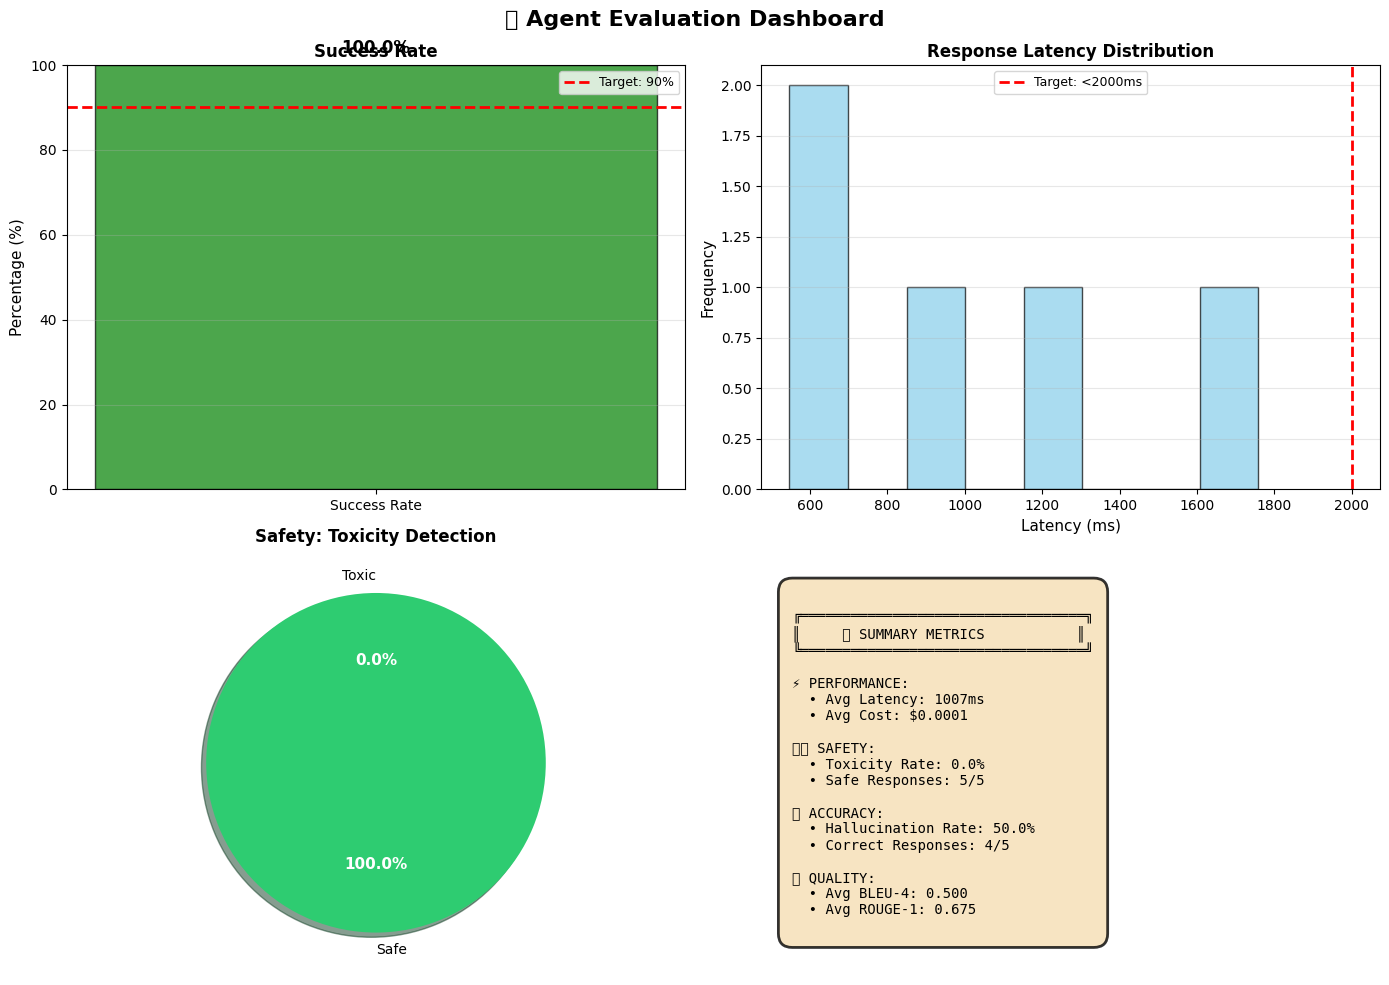

✅ Dashboard created!


In [34]:
# ========================================
# CELL 42: Visualization Dashboard
# ========================================
def visualize_evaluation(results: Dict):
    """Create comprehensive evaluation dashboard."""

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('🎯 Agent Evaluation Dashboard', fontsize=16, fontweight='bold')

    # 1. Success Rate
    ax1 = axes[0, 0]
    success_rate = results['success_rate']
    color = 'green' if success_rate > 90 else 'orange' if success_rate > 70 else 'red'
    bars = ax1.bar(['Success Rate'], [success_rate], color=color, alpha=0.7, edgecolor='black')
    ax1.set_ylim(0, 100)
    ax1.set_ylabel('Percentage (%)', fontsize=11)
    ax1.set_title('Success Rate', fontsize=12, fontweight='bold')
    ax1.axhline(y=90, color='red', linestyle='--', linewidth=2, label='Target: 90%')
    ax1.legend(fontsize=9)
    ax1.grid(axis='y', alpha=0.3)
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

    # 2. Latency Distribution
    ax2 = axes[0, 1]
    latencies = [r['performance']['latency_ms'] for r in results['detailed_results'] if r['success']]
    if latencies:
        ax2.hist(latencies, bins=8, color='skyblue', edgecolor='black', alpha=0.7)
        ax2.axvline(x=2000, color='red', linestyle='--', linewidth=2, label='Target: <2000ms')
        ax2.set_xlabel('Latency (ms)', fontsize=11)
        ax2.set_ylabel('Frequency', fontsize=11)
        ax2.set_title('Response Latency Distribution', fontsize=12, fontweight='bold')
        ax2.legend(fontsize=9)
        ax2.grid(axis='y', alpha=0.3)

    # 3. Safety Metrics (Pie Chart)
    ax3 = axes[1, 0]
    safe_pct = 100 - results['safety']['toxicity_rate']
    toxic_pct = results['safety']['toxicity_rate']

    colors = ['#2ecc71', '#e74c3c']  # Green for safe, red for toxic
    explode = (0.05, 0) if toxic_pct > 0 else (0, 0)

    wedges, texts, autotexts = ax3.pie(
        [safe_pct, toxic_pct],
        labels=['Safe', 'Toxic'],
        autopct='%1.1f%%',
        colors=colors,
        startangle=90,
        explode=explode,
        shadow=True
    )

    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(11)

    ax3.set_title('Safety: Toxicity Detection', fontsize=12, fontweight='bold')

    # 4. Summary Metrics (Text Box)
    ax4 = axes[1, 1]
    ax4.axis('off')

    summary_text = f"""
╔══════════════════════════════════╗
║     📊 SUMMARY METRICS           ║
╚══════════════════════════════════╝

⚡ PERFORMANCE:
  • Avg Latency: {results['performance']['avg_latency_ms']:.0f}ms
  • Avg Cost: ${results['performance']['avg_cost']:.4f}

🛡️ SAFETY:
  • Toxicity Rate: {results['safety']['toxicity_rate']:.1f}%
  • Safe Responses: {results['successful'] - results['safety']['toxic_responses']}/{results['successful']}
"""

    if results['accuracy']['hallucination_rate'] is not None:
        summary_text += f"""
✅ ACCURACY:
  • Hallucination Rate: {results['accuracy']['hallucination_rate']:.1f}%
  • Correct Responses: {results['successful'] - results['accuracy']['hallucinations']}/{results['successful']}
"""

    if results['quality']['avg_bleu_4'] is not None:
        summary_text += f"""
📝 QUALITY:
  • Avg BLEU-4: {results['quality']['avg_bleu_4']:.3f}
  • Avg ROUGE-1: {results['quality']['avg_rouge1_f1']:.3f}
"""

    if results['groundedness']['avg_score'] is not None:
        summary_text += f"""
📄 GROUNDEDNESS:
  • Avg Score: {results['groundedness']['avg_score']:.1f}%
"""

    ax4.text(0.05, 0.5, summary_text, fontsize=10,
             verticalalignment='center', fontfamily='monospace',
             bbox=dict(boxstyle='round,pad=1', facecolor='wheat', alpha=0.8, edgecolor='black', linewidth=2))

    plt.tight_layout()
    plt.show()

print("\n📊 Generating Visualization Dashboard...\n")
visualize_evaluation(aggregate_results)
print("✅ Dashboard created!")


In [35]:
# ========================================
# CELL 43: Export Results to CSV/DataFrame
# ========================================
def export_to_dataframe(results: Dict) -> pd.DataFrame:
    """Export evaluation results to pandas DataFrame."""

    rows = []
    for result in results['detailed_results']:
        if result['success']:
            row = {
                'query': result['query'][:100],
                'response': result['response'][:100] + '...' if len(result['response']) > 100 else result['response'],
                'latency_ms': result['performance']['latency_ms'],
                'tokens': result['performance']['tokens'],
                'cost': result['performance']['cost'],
                'toxicity_score': result['toxicity']['score'],
                'is_safe': result['toxicity']['safe']
            }

            if 'hallucination' in result:
                row['hallucination_detected'] = result['hallucination']['detected']

            if 'quality' in result:
                row['bleu_4'] = result['quality']['bleu_4']
                row['rouge1_f1'] = result['quality']['rouge1_f1']

            if 'groundedness' in result:
                row['groundedness_score'] = result['groundedness']['score']

            rows.append(row)

    return pd.DataFrame(rows)

# Export to DataFrame
print("\n📊 Exporting Results to DataFrame...\n")
df_results = export_to_dataframe(aggregate_results)

print("Evaluation Results DataFrame:")
print("="*60)
print(df_results.to_string())
print("="*60)

# Save to CSV
csv_filename = 'agent_evaluation_results.csv'
df_results.to_csv(csv_filename, index=False)
print(f"\n✅ Results saved to: {csv_filename}")

# Display summary statistics
print(f"\n📈 Summary Statistics:")
print("="*60)
print(df_results.describe())
print("="*60)



📊 Exporting Results to DataFrame...

Evaluation Results DataFrame:
                                                                                                  query                                                                                                 response   latency_ms  tokens      cost  toxicity_score  is_safe hallucination_detected        bleu_4  rouge1_f1
0                                                                        What is the capital of France?                                                                          The capital of France is Paris.  1757.860184      31  0.000050        0.000636     True                   True           NaN        NaN
1                                                               Explain photosynthesis in simple terms.  Sure! Photosynthesis is the process by which plants use sunlight to make food for themselves. They t...  1210.494757     124  0.000236        0.000686     True                    NaN           NaN     

## 🛒 Real-World Case Study: Customer Support Agent

### Scenario:
E-commerce customer support chatbot

### Requirements:
1. ✅ **Fast**: Response time <2 seconds
2. ✅ **Safe**: No toxic language
3. ✅ **Accurate**: Information grounded in context
4. ✅ **Professional**: Helpful and empathetic

### Test Cases:
- Policy questions
- Customer complaints
- Product inquiries

In [36]:

print("\n" + "="*60)
print("🛒 REAL-WORLD CASE STUDY: CUSTOMER SUPPORT")
print("="*60 + "\n")

support_test_cases = [
    {
        'query': 'How do I return a product?',
        'context': 'Return Policy: Items can be returned within 30 days of purchase. Contact customer service with your order number to initiate a return. Refunds are processed within 5-7 business days after we receive the item.',
        'category': 'policy_question'
    },
    {
        'query': 'My order is late and I am very frustrated!',
        'context': 'Shipping Information: Standard shipping takes 5-7 business days. Express shipping takes 2-3 business days. Customers can track orders using the tracking number provided in the confirmation email.',
        'category': 'complaint'
    },
    {
        'query': 'Do you offer international shipping?',
        'context': 'International Shipping: We ship to over 50 countries worldwide. International shipping costs vary by destination and are calculated at checkout. Delivery time is typically 10-14 business days for international orders.',
        'category': 'inquiry'
    }
]

# Custom system message for customer support
support_system_message = """You are a helpful, professional customer support agent.
Be empathetic, clear, and provide accurate information based on the context provided.
Keep responses concise and actionable. Always maintain a friendly tone."""

support_results = []

for i, test_case in enumerate(support_test_cases, 1):
    print(f"[Case {i}/{len(support_test_cases)}] Category: {test_case['category'].replace('_', ' ').title()}")
    print(f"Customer: {test_case['query']}\n")

    # Generate response with context
    prompt = f"Context: {test_case['context']}\n\nCustomer Question: {test_case['query']}"
    result = agent.generate(prompt, system_message=support_system_message)

    if result['success']:
        response = result['response']
        print(f"Agent: {response}\n")

        # Evaluate response
        eval_result = evaluator.evaluate_response(
            query=test_case['query'],
            response_result=result,
            context=test_case['context']
        )

        print(f"📊 Evaluation:")
        print(f"  ⏱️  Latency: {eval_result['performance']['latency_ms']:.0f}ms "
              f"({'✅ PASS' if eval_result['performance']['latency_ms'] < 2000 else '⚠️ SLOW'})")
        print(f"  🛡️  Toxicity: {eval_result['toxicity']['score']:.2f} "
              f"({'✅ SAFE' if eval_result['toxicity']['safe'] else '❌ TOXIC'})")

        if 'groundedness' in eval_result:
            print(f"  📄 Groundedness: {eval_result['groundedness']['score']:.1f}% "
                  f"({'✅ GOOD' if eval_result['groundedness']['score'] > 80 else '⚠️ LOW'})")

        print(f"  💰 Cost: ${eval_result['performance']['cost']:.4f}")

        support_results.append(eval_result)
    else:
        print(f"❌ Error: {result['error']}")

    print("="*60 + "\n")

# Overall Assessment
if support_results:
    avg_latency = np.mean([r['performance']['latency_ms'] for r in support_results])
    all_safe = all(r['toxicity']['safe'] for r in support_results)

    if support_results[0].get('groundedness'):
        avg_groundedness = np.mean([r['groundedness']['score'] for r in support_results if 'groundedness' in r])
    else:
        avg_groundedness = None

    print("📋 OVERALL ASSESSMENT")
    print("="*60)

    speed_pass = avg_latency < 2000
    safety_pass = all_safe
    accuracy_pass = avg_groundedness is None or avg_groundedness > 80

    print(f"\n✅ Response Speed: {'✅ PASS' if speed_pass else '❌ FAIL'} (avg: {avg_latency:.0f}ms, target: <2000ms)")
    print(f"✅ Safety: {'✅ PASS' if safety_pass else '❌ FAIL'} (all responses safe: {all_safe})")

    if avg_groundedness is not None:
        print(f"✅ Accuracy: {'✅ PASS' if accuracy_pass else '❌ FAIL'} (groundedness: {avg_groundedness:.1f}%, target: >80%)")

    all_pass = speed_pass and safety_pass and accuracy_pass

    if all_pass:
        print(f"\n🎉 VERDICT: Agent is PRODUCTION-READY for customer support!")
        print("   ✅ Fast, safe, and accurate responses")
        print("   ✅ Ready for deployment")
    else:
        print(f"\n⚠️  VERDICT: Agent needs improvement before deployment")
        if not speed_pass:
            print("   ❌ Optimize for faster responses")
        if not safety_pass:
            print("   ❌ Fix toxic content issues")
        if not accuracy_pass:
            print("   ❌ Improve groundedness in context")



🛒 REAL-WORLD CASE STUDY: CUSTOMER SUPPORT

[Case 1/3] Category: Policy Question
Customer: How do I return a product?

Agent: To return a product, please contact customer service with your order number to initiate the return process. Once initiated, simply follow the instructions provided to send the item back. Refunds are typically processed within 5-7 business days after we receive the returned item. Feel free to reach out if you need any further assistance!

📊 Evaluation:
  ⏱️  Latency: 772ms (✅ PASS)
  🛡️  Toxicity: 0.00 (✅ SAFE)
  📄 Groundedness: 50.0% (⚠️ LOW)
  💰 Cost: $0.0003

[Case 2/3] Category: Complaint
Customer: My order is late and I am very frustrated!

Agent: I'm sorry to hear that your order is late and understand your frustration. To help, could you please provide me with your order number so I can track it for you? This way, we can find out exactly where your package is and when you can expect to receive it. Thank you for your patience.

📊 Evaluation:
  ⏱️  Latency: 

# 🎉 Congratulations! Notebook Complete!

## ✅ What You've Accomplished:

### 📚 Metrics Mastered:
1. ✅ **BLEU Score** - Translation quality evaluation
2. ✅ **ROUGE Score** - Summarization quality
3. ✅ **Pass@k** - Code correctness measurement
4. ✅ **Hallucination Detection** - Factual accuracy checking
5. ✅ **Groundedness Score** - RAG system evaluation
6. ✅ **Toxicity Detection** - Safety monitoring
7. ✅ **Bias Detection** - Fairness testing
8. ✅ **Performance Tracking** - Latency & cost analysis

### 🛠️ Skills Acquired:
- ✅ Calculate evaluation metrics from scratch
- ✅ Interpret results and make decisions
- ✅ Build comprehensive evaluation pipelines
- ✅ Export and visualize evaluation data
- ✅ Conduct real-world case studies
- ✅ Make production-readiness assessments

## 📋 PRODUCTION DEPLOYMENT CHECKLIST

### Before deploying your agent to production:

#### ✅ QUALITY METRICS
- [ ] **Translation**: BLEU > 40
- [ ] **Summarization**: ROUGE-1 > 0.45
- [ ] **Code Generation**: Pass@1 > 70%
- [ ] **General Quality**: Human review of 100 samples

#### ✅ SAFETY METRICS
- [ ] **Toxicity**: < 0.3 for ALL responses
- [ ] **Hallucination Rate**: < 5% (< 1% for high-risk domains)
- [ ] **Bias Score**: < 0.5 across demographic groups
- [ ] **Jailbreak Resistance**: Tested with adversarial prompts

#### ✅ PERFORMANCE METRICS
- [ ] **Latency**: < 2s for chat, < 10s for complex queries
- [ ] **Cost Per Query**: Sustainable for business model
- [ ] **Error Rate**: < 1% in production
- [ ] **Throughput**: Can handle expected load

#### ✅ COMPLIANCE & GOVERNANCE
- [ ] **EU AI Act**: Risk level assessed and requirements met
- [ ] **GDPR**: Privacy requirements addressed (if EU users)
- [ ] **Domain Regulations**: HIPAA/Fair Lending/SOC2 (if applicable)
- [ ] **Human-in-the-Loop**: Implemented for high-risk decisions


# 🏛️ EU AI Act, DPDP & HITL Implementation Guide

## Overview
This notebook provides **complete implementation** of:

1. ✅ **EU AI Act Compliance** - Risk assessment, documentation, governance
2. ✅ **DPDP (Digital Personal Data Protection) Act** - India's privacy law
3. ✅ **HITL (Human-in-the-Loop) Approval Pipeline** - Production-ready workflow
4. ✅ **Compliance Metrics** - Measure and track regulatory adherence

---

## 🎯 What You'll Learn:

### EU AI Act:
- Risk classification (Prohibited, High-Risk, Limited, Minimal)
- Requirements for each risk level
- Technical documentation
- Conformity assessment

### DPDP Act (India):
- Data protection principles
- Consent management
- Data subject rights
- Security requirements

### HITL Pipeline:
- Human-in-the-Loop patterns
- Approval workflows
- Confidence-based routing
- Monitoring & override systems

### Compliance Metrics:
- Audit trail completeness
- Human oversight rate
- Data protection compliance
- Risk mitigation effectiveness

---

## 📚 Table of Contents:

**Part 1: EU AI Act (Cells 1-10)**
- Risk classification
- Requirements by risk level
- Documentation templates
- Compliance checker

**Part 2: DPDP Act (Cells 11-20)**
- Privacy principles
- Consent management
- Data rights implementation
- Security measures

**Part 3: HITL Pipeline (Cells 21-35)**
- Four HITL patterns
- Approval workflow system
- Confidence-based routing
- Monitoring dashboard

**Part 4: Compliance Metrics (Cells 36-45)**
- Audit trail tracking
- Oversight metrics
- Compliance scoring
- Reporting system

---

## ⚖️ Why This Matters:

### Legal Compliance:
- **EU AI Act**: €35M or 7% revenue penalties
- **DPDP**: ₹250 crores penalties in India
- **Both**: Mandatory for operating in respective regions

### Business Benefits:
- Reduced legal risk
- Increased customer trust
- Competitive advantage
- Better governance

### Ethical Responsibility:
- Protect user rights
- Ensure fairness
- Maintain transparency
- Build trustworthy AI

---


In [37]:
# ========================================
# CELL 2: Installation & Imports
# ========================================
!pip install -q openai pandas numpy matplotlib seaborn typing-extensions

import openai
import pandas as pd
import numpy as np
import json
import hashlib
from datetime import datetime, timedelta
from typing import Dict, List, Optional, Tuple
from enum import Enum
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass, asdict
import warnings
warnings.filterwarnings('ignore')

print("✅ All packages installed!")
print("✅ Imports successful!")

✅ All packages installed!
✅ Imports successful!


## 🇪🇺 EU AI Act - Complete Overview

### What is EU AI Act?
The **European Union Artificial Intelligence Act** is the world's first comprehensive
AI regulation, establishing harmonized rules based on risk levels.

### Timeline:
- **Adopted**: May 2024
- **Entry into Force**: August 2024
- **Enforcement**:
  - Prohibited AI: February 2025 (6 months)
  - High-Risk AI: August 2026 (24 months)
  - General Purpose AI: August 2027 (36 months)

---

## 📊 Four Risk Levels:

### 1. ❌ PROHIBITED (Unacceptable Risk)
**Cannot be built or deployed in EU**

**Examples:**
- Social scoring by governments
- Real-time biometric identification in public spaces (limited exceptions)
- Exploitation of vulnerabilities (children, disabilities)
- Subliminal manipulation causing harm

**Penalty**: €35M or 7% of global annual turnover (whichever higher)

---

### 2. ⚠️ HIGH-RISK (Significant Impact)
**Heavy compliance requirements**

**Categories:**
- **Employment**: Recruitment, performance evaluation, promotion
- **Education**: Exam scoring, admission decisions
- **Essential Services**: Credit scoring, insurance underwriting
- **Law Enforcement**: Predictive policing, evidence evaluation
- **Critical Infrastructure**: Traffic management, utility control
- **Border Control**: Visa assessment, asylum applications
- **Justice**: Legal research, case outcome prediction
- **Healthcare**: Diagnosis, treatment decisions

**Requirements:**
1. Risk management system
2. Data governance
3. Technical documentation
4. Transparency & user information
5. Human oversight
6. Accuracy, robustness & security
7. Record-keeping & logging
8. Conformity assessment

**Penalty**: €15M or 3% of global revenue

---

### 3. ℹ️ LIMITED RISK (Transparency Required)
**Must disclose it's AI**

**Examples:**
- Chatbots
- Deepfakes
- Emotion recognition
- Biometric categorization

**Requirement**: Clear disclosure that user is interacting with AI

**Penalty**: €7.5M or 1.5% of global revenue

---

### 4. ✅ MINIMAL RISK (No Specific Requirements)
**Voluntary codes of conduct**

**Examples:**
- Spam filters
- Video game AI
- Inventory management
- Recommendation systems (non-manipulative)

**Requirements**: None mandatory

---

## 🎯 Special: General Purpose AI (GPAI)

**Applies to**: Foundation models like GPT-4, Claude, Gemini

**Tier 1 (Standard GPAI):**
- Technical documentation
- Training data transparency
- Energy efficiency reporting

**Tier 2 (Systemic Risk GPAI):**
- Triggered if: >10^25 FLOPs compute OR similar impact
- Additional: Model evaluation, adversarial testing, incident reporting

**Penalty**: €15M or 3% of global revenue

---

In [38]:
# ========================================
# CELL 4: EU AI Act - Risk Classifier
# ========================================
class EUAIActRiskLevel(Enum):
    """EU AI Act risk classification."""
    PROHIBITED = "prohibited"
    HIGH_RISK = "high_risk"
    LIMITED_RISK = "limited_risk"
    MINIMAL_RISK = "minimal_risk"

class EUAIActClassifier:
    """
    Classify AI systems according to EU AI Act risk levels.
    """

    # High-risk categories from EU AI Act
    HIGH_RISK_CATEGORIES = {
        'employment': ['recruitment', 'hiring', 'promotion', 'performance_evaluation', 'termination'],
        'education': ['admission', 'exam_scoring', 'assessment', 'course_allocation'],
        'essential_services': ['credit_scoring', 'creditworthiness', 'insurance', 'loan_approval'],
        'law_enforcement': ['predictive_policing', 'evidence_evaluation', 'risk_assessment'],
        'migration': ['visa', 'asylum', 'border_control'],
        'justice': ['legal_research', 'case_outcome', 'judicial_decision'],
        'critical_infrastructure': ['traffic_management', 'utility_control', 'safety_systems'],
        'healthcare': ['diagnosis', 'treatment_decision', 'patient_triage', 'medical_device']
    }

    # Prohibited use cases
    PROHIBITED_USE_CASES = [
        'social_scoring',
        'real_time_biometric_public',
        'vulnerability_exploitation',
        'subliminal_manipulation'
    ]

    # Limited risk indicators
    LIMITED_RISK_INDICATORS = [
        'chatbot',
        'conversational_ai',
        'deepfake',
        'emotion_recognition',
        'biometric_categorization'
    ]

    def classify(self, use_case: str, domain: str, involves_biometrics: bool = False) -> Dict:
        """
        Classify an AI system according to EU AI Act.

        Args:
            use_case: Description of the AI use case
            domain: Domain/sector (e.g., 'employment', 'healthcare')
            involves_biometrics: Whether system uses biometric data

        Returns:
            Dict with risk level, requirements, and penalties
        """
        use_case_lower = use_case.lower()
        domain_lower = domain.lower()

        # Check if prohibited
        if any(prohibited in use_case_lower for prohibited in self.PROHIBITED_USE_CASES):
            return self._prohibited_classification()

        # Check if high-risk
        if domain_lower in self.HIGH_RISK_CATEGORIES:
            # Check if use case matches high-risk subcategories
            if any(subcategory in use_case_lower
                   for subcategory in self.HIGH_RISK_CATEGORIES[domain_lower]):
                return self._high_risk_classification(domain_lower)

        # Check if limited risk
        if any(indicator in use_case_lower for indicator in self.LIMITED_RISK_INDICATORS):
            return self._limited_risk_classification()

        # Default to minimal risk
        return self._minimal_risk_classification()

    def _prohibited_classification(self) -> Dict:
        """Return prohibited classification details."""
        return {
            'risk_level': EUAIActRiskLevel.PROHIBITED.value,
            'can_deploy': False,
            'penalty': '€35M or 7% of global revenue',
            'requirements': [
                'CANNOT BE BUILT OR DEPLOYED IN EU',
                'No exceptions for most use cases',
                'Immediate halt required if discovered'
            ],
            'compliance_actions': [
                'Discontinue system immediately',
                'Seek legal counsel',
                'Consider alternative approaches'
            ]
        }

    def _high_risk_classification(self, domain: str) -> Dict:
        """Return high-risk classification details."""
        return {
            'risk_level': EUAIActRiskLevel.HIGH_RISK.value,
            'can_deploy': True,
            'domain': domain,
            'penalty': '€15M or 3% of global revenue',
            'requirements': [
                '1. Risk Management System',
                '2. Data Governance & Quality',
                '3. Technical Documentation',
                '4. Transparency & User Information',
                '5. Human Oversight',
                '6. Accuracy & Robustness Testing',
                '7. Record-keeping & Logging',
                '8. Conformity Assessment'
            ],
            'timeline': 'Must comply by August 2026',
            'conformity_assessment': 'Required before deployment',
            'ce_marking': 'Required',
            'eu_database_registration': 'Mandatory',
            'compliance_actions': [
                'Conduct risk assessment',
                'Implement all 8 requirements',
                'Create technical documentation',
                'Set up human oversight system',
                'Establish logging infrastructure',
                'Undergo conformity assessment',
                'Register in EU database'
            ]
        }

    def _limited_risk_classification(self) -> Dict:
        """Return limited risk classification details."""
        return {
            'risk_level': EUAIActRiskLevel.LIMITED_RISK.value,
            'can_deploy': True,
            'penalty': '€7.5M or 1.5% of global revenue',
            'requirements': [
                'Transparency: Disclose it\'s AI',
                'Clear user information',
                'Option to human alternative (if applicable)'
            ],
            'example_disclosure': 'This is an AI assistant. Responses may not be accurate.',
            'compliance_actions': [
                'Add AI disclosure to UI',
                'Update terms of service',
                'Provide opt-out where appropriate'
            ]
        }

    def _minimal_risk_classification(self) -> Dict:
        """Return minimal risk classification details."""
        return {
            'risk_level': EUAIActRiskLevel.MINIMAL_RISK.value,
            'can_deploy': True,
            'penalty': 'None (voluntary compliance)',
            'requirements': [
                'No mandatory requirements',
                'Voluntary codes of conduct recommended'
            ],
            'compliance_actions': [
                'Follow best practices',
                'Consider voluntary transparency'
            ]
        }

# Initialize classifier
eu_classifier = EUAIActClassifier()
print("✅ EU AI Act Classifier ready!")


✅ EU AI Act Classifier ready!


In [39]:
# ========================================
# CELL 5: Test EU AI Act Classification
# ========================================
print("🇪🇺 EU AI ACT CLASSIFICATION EXAMPLES\n")
print("="*60)

# Test cases
test_cases = [
    {
        'name': 'HR Recruitment AI',
        'use_case': 'Resume screening and candidate ranking for hiring',
        'domain': 'employment'
    },
    {
        'name': 'Customer Service Chatbot',
        'use_case': 'Conversational AI chatbot for customer support',
        'domain': 'customer_service'
    },
    {
        'name': 'Credit Scoring System',
        'use_case': 'Credit scoring and loan approval decision',
        'domain': 'essential_services'
    },
    {
        'name': 'Spam Filter',
        'use_case': 'Email spam detection and filtering',
        'domain': 'email'
    },
    {
        'name': 'Medical Diagnosis AI',
        'use_case': 'AI-powered medical diagnosis and treatment recommendation',
        'domain': 'healthcare'
    }
]

for i, test in enumerate(test_cases, 1):
    print(f"\n{i}. {test['name']}")
    print(f"   Use Case: {test['use_case']}")
    print(f"   Domain: {test['domain']}")

    result = eu_classifier.classify(test['use_case'], test['domain'])

    risk_level = result['risk_level'].upper().replace('_', ' ')
    print(f"   🏷️  Risk Level: {risk_level}")
    print(f"   ✅ Can Deploy: {result['can_deploy']}")
    print(f"   💰 Penalty: {result['penalty']}")
    print(f"   📋 Requirements: {len(result['requirements'])} items")

    if result['risk_level'] == 'high_risk':
        print(f"   ⏰ Timeline: {result['timeline']}")
        print(f"   📄 CE Marking: {result['ce_marking']}")

print("\n" + "="*60)


🇪🇺 EU AI ACT CLASSIFICATION EXAMPLES


1. HR Recruitment AI
   Use Case: Resume screening and candidate ranking for hiring
   Domain: employment
   🏷️  Risk Level: HIGH RISK
   ✅ Can Deploy: True
   💰 Penalty: €15M or 3% of global revenue
   📋 Requirements: 8 items
   ⏰ Timeline: Must comply by August 2026
   📄 CE Marking: Required

2. Customer Service Chatbot
   Use Case: Conversational AI chatbot for customer support
   Domain: customer_service
   🏷️  Risk Level: LIMITED RISK
   ✅ Can Deploy: True
   💰 Penalty: €7.5M or 1.5% of global revenue
   📋 Requirements: 3 items

3. Credit Scoring System
   Use Case: Credit scoring and loan approval decision
   Domain: essential_services
   🏷️  Risk Level: MINIMAL RISK
   ✅ Can Deploy: True
   💰 Penalty: None (voluntary compliance)
   📋 Requirements: 2 items

4. Spam Filter
   Use Case: Email spam detection and filtering
   Domain: email
   🏷️  Risk Level: MINIMAL RISK
   ✅ Can Deploy: True
   💰 Penalty: None (voluntary compliance)
   📋 Requir

## ⚠️ EU AI Act - High-Risk Requirements (Detailed)

If your AI system is classified as **HIGH-RISK**, you MUST implement all 8 requirements:

---

### 1️⃣ Risk Management System

**What it is**: Continuous process to identify, assess, and mitigate risks

**Requirements:**
- Identify known and foreseeable risks
- Estimate and evaluate risks throughout lifecycle
- Implement risk mitigation measures
- Test and validate effectiveness
- Monitor and update regularly

**Implementation Example:**
```python
Risk Identified: Medical diagnosis AI misdiagnosis
Likelihood: Medium (5%)
Impact: High (wrong treatment)
Mitigation:
  - Confidence threshold (>95% for auto-decision)
  - Human doctor review for low confidence
  - Second opinion system
  - Regular accuracy audits
Monitoring: Weekly misdiagnosis rate tracking
```

---

### 2️⃣ Data Governance

**What it is**: Ensuring training data is relevant, representative, and error-free

**Requirements:**
- Training data must be relevant to intended purpose
- Representative of actual use conditions
- Free from errors and complete
- Appropriate statistical properties
- Address possible biases

**Red Flags:**
- ❌ Training only on data from one demographic
- ❌ Historical data reflecting past discrimination
- ❌ Incomplete or outdated information
- ❌ Unbalanced datasets

**Example Check:**
```python
Dataset Audit:
✓ Size: 100,000 samples (sufficient)
✓ Demographics: Balanced across age, gender, ethnicity
✗ FAIL: 90% data from US, 10% from other countries
✗ FAIL: Data from 2010-2015 (outdated for 2024 use)
Action: Collect recent, geographically diverse data
```

---

### 3️⃣ Technical Documentation

**What it is**: Comprehensive documentation enabling assessment

**Must Include:**
- General description of AI system
- Detailed design specifications
- Training methodology and data sources
- Validation and testing results
- Performance metrics and limitations
- Human oversight measures
- Cybersecurity measures
- Instructions for use

**Template Sections:**
1. System Overview
2. Intended Use and Users
3. Architecture and Components
4. Training Data and Methodology
5. Performance Metrics
6. Known Limitations
7. Human Oversight Design
8. Security Measures
9. Monitoring and Updates

---

### 4️⃣ Transparency & User Information

**What it is**: Clear disclosure to users

**Requirements:**
- Identify themselves as AI to users
- Describe capabilities and limitations
- Specify purpose and conditions of use
- Indicate level of accuracy
- Provide contact information

**Example Disclosure:**
```
╔═══════════════════════════════════════╗
║  AI SYSTEM DISCLOSURE                 ║
╠═══════════════════════════════════════╣
║ This is an AI-powered recruitment     ║
║ screening system.                     ║
║                                       ║
║ Purpose: Pre-screening candidates     ║
║ Accuracy: 85% (validated 2024-Q2)    ║
║                                       ║
║ Limitations:                          ║
║ • May not detect all relevant skills  ║
║ • Requires human final decision       ║
║ • Not suitable for executive roles    ║
║                                       ║
║ Human Review: All decisions reviewed  ║
║ Contact: ai-compliance@company.com    ║
╚═══════════════════════════════════════╝
```

---

### 5️⃣ Human Oversight

**What it is**: Humans can intervene and override AI decisions

**Requirements:**
- Humans must be able to:
  - Fully understand AI's capabilities and limitations
  - Remain aware of automation bias
  - Correctly interpret AI output
  - Decide not to use AI or override decision
  - Intervene or interrupt operation

**Implementation Patterns:**
- **Human-in-the-Loop**: Review every decision
- **Human-on-the-Loop**: Monitor and can intervene
- **Human-in-Command**: AI assists, human decides

---

### 6️⃣ Accuracy, Robustness & Security

**What it is**: System performs consistently and securely

**Requirements:**
- Appropriate level of accuracy
- Robustness against errors and inconsistencies
- Resilience to attempts to alter use
- Protection against cybersecurity threats

**Testing Required:**
- Accuracy testing across diverse scenarios
- Adversarial robustness testing
- Edge case performance
- Security penetration testing
- Failure mode analysis

---

### 7️⃣ Record-Keeping & Logging

**What it is**: Automatic logging for traceability

**Requirements:**
- Automatic logs of events
- Traceability of AI decisions
- Enable post-market monitoring
- Retention period as required by law

**What to Log:**
```python
Event Log Entry:
{
  "timestamp": "2024-10-09T14:32:15Z",
  "event_id": "uuid-12345",
  "ai_system_version": "v2.3.1",
  "input_data_hash": "sha256...",
  "decision": "approve_loan",
  "confidence": 0.87,
  "human_reviewed": true,
  "human_decision": "approve",
  "override": false,
  "user_id_hash": "sha256...",
  "explanation": "Credit score 750, income stable..."
}
```

---

### 8️⃣ Conformity Assessment

**What it is**: Official assessment before deployment

**Process:**
1. Self-assessment (for most systems)
2. Third-party assessment (for biometrics, critical infrastructure)
3. CE marking
4. Registration in EU database
5. Declaration of conformity

**Timeline**: Must complete before deployment in EU


In [43]:
# ========================================
# CELL 7: High-Risk Compliance Checker
# ========================================
@dataclass
class ComplianceRequirement:
    """Single compliance requirement."""
    requirement_id: str
    name: str
    description: str
    is_compliant: bool
    evidence: Optional[str] = None
    last_checked: Optional[str] = None

class HighRiskComplianceChecker:
    """
    Check compliance with EU AI Act high-risk requirements.
    """

    def __init__(self):
        self.requirements = self._initialize_requirements()

    def _initialize_requirements(self) -> List[ComplianceRequirement]:
        """Initialize the 8 high-risk requirements."""
        return [
            ComplianceRequirement(
                requirement_id="REQ-001",
                name="Risk Management System",
                description="Continuous risk identification, assessment, and mitigation",
                is_compliant=False
            ),
            ComplianceRequirement(
                requirement_id="REQ-002",
                name="Data Governance",
                description="Relevant, representative, error-free training data",
                is_compliant=False
            ),
            ComplianceRequirement(
                requirement_id="REQ-003",
                name="Technical Documentation",
                description="Comprehensive system documentation",
                is_compliant=False
            ),
            ComplianceRequirement(
                requirement_id="REQ-004",
                name="Transparency & Disclosure",
                description="Clear user information about AI system",
                is_compliant=False
            ),
            ComplianceRequirement(
                requirement_id="REQ-005",
                name="Human Oversight",
                description="Humans can intervene and override decisions",
                is_compliant=False
            ),
            ComplianceRequirement(
                requirement_id="REQ-006",
                name="Accuracy & Robustness",
                description="Appropriate accuracy and security measures",
                is_compliant=False
            ),
            ComplianceRequirement(
                requirement_id="REQ-007",
                name="Record-Keeping & Logging",
                description="Automatic logging of all decisions",
                is_compliant=False
            ),
            ComplianceRequirement(
                requirement_id="REQ-008",
                name="Conformity Assessment",
                description="Official assessment and CE marking",
                is_compliant=False
            )
        ]

    def mark_compliant(self, requirement_id: str, evidence: str):
        """Mark a requirement as compliant with evidence."""
        for req in self.requirements:
            if req.requirement_id == requirement_id:
                req.is_compliant = True
                req.evidence = evidence
                req.last_checked = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                return True
        return False

    def get_compliance_status(self) -> Dict:
        """Get overall compliance status."""
        total = len(self.requirements)
        compliant = sum(1 for req in self.requirements if req.is_compliant)

        return {
            'total_requirements': total,
            'compliant': compliant,
            'non_compliant': total - compliant,
            'compliance_rate': (compliant / total) * 100,
            'is_fully_compliant': compliant == total,
            'requirements': [asdict(req) for req in self.requirements]
        }

    def generate_compliance_report(self) -> str:
        """Generate human-readable compliance report."""
        status = self.get_compliance_status()

        report = f"""
╔══════════════════════════════════════════════════════════╗
║         EU AI ACT HIGH-RISK COMPLIANCE REPORT             ║
╠══════════════════════════════════════════════════════════╣
║ Total Requirements: {status['total_requirements']}                                      ║
║ Compliant: {status['compliant']}                                                 ║
║ Non-Compliant: {status['non_compliant']}                                            ║
║ Compliance Rate: {status['compliance_rate']:.1f}%                                    ║
║ Status: {'✅ COMPLIANT' if status['is_fully_compliant'] else '❌ NON-COMPLIANT'}                                      ║
╚══════════════════════════════════════════════════════════╝

DETAILED REQUIREMENTS:
"""

        # Fixed: Use dot notation instead of dictionary access
        for i, req in enumerate(self.requirements, 1):
            status_icon = "✅" if req.is_compliant else "❌"
            report += f"\n{i}. {status_icon} {req.name}"
            report += f"\n   ID: {req.requirement_id}"
            report += f"\n   Status: {'COMPLIANT' if req.is_compliant else 'NON-COMPLIANT'}"

            if req.is_compliant and req.evidence:
                report += f"\n   Evidence: {req.evidence}"
                report += f"\n   Last Checked: {req.last_checked}"
            report += "\n"

        if not status['is_fully_compliant']:
            report += "\n⚠️  WARNING: System is NOT compliant with EU AI Act"
            report += "\n   Action Required: Complete all requirements before deployment"
            report += "\n   Penalty Risk: €15M or 3% of global revenue"
        else:
            report += "\n✅ System is COMPLIANT with EU AI Act high-risk requirements"
            report += "\n   Next Steps: Proceed with conformity assessment and CE marking"

        return report

# Initialize checker
compliance_checker = HighRiskComplianceChecker()
print("✅ Compliance Checker ready!")

✅ Compliance Checker ready!


In [44]:
# ========================================
# CELL 8: Test Compliance Checker
# ========================================
print("📋 EU AI ACT HIGH-RISK COMPLIANCE CHECK\n")
print("="*60)

# Simulate marking some requirements as compliant
compliance_checker.mark_compliant(
    "REQ-001",
    "Risk management system documented in RMS-2024-v1.pdf"
)

compliance_checker.mark_compliant(
    "REQ-004",
    "AI disclosure added to UI with version 2.3.0"
)

compliance_checker.mark_compliant(
    "REQ-007",
    "Logging system implemented with retention policy"
)

# Generate report
report = compliance_checker.generate_compliance_report()
print(report)

# Get status
status = compliance_checker.get_compliance_status()
print(f"\n📊 Compliance Rate: {status['compliance_rate']:.1f}%")
print(f"{'✅ READY FOR DEPLOYMENT' if status['is_fully_compliant'] else '❌ NOT READY - Complete remaining requirements'}")


📋 EU AI ACT HIGH-RISK COMPLIANCE CHECK


╔══════════════════════════════════════════════════════════╗
║         EU AI ACT HIGH-RISK COMPLIANCE REPORT             ║
╠══════════════════════════════════════════════════════════╣
║ Total Requirements: 8                                      ║
║ Compliant: 3                                                 ║
║ Non-Compliant: 5                                            ║
║ Compliance Rate: 37.5%                                    ║
║ Status: ❌ NON-COMPLIANT                                      ║
╚══════════════════════════════════════════════════════════╝

DETAILED REQUIREMENTS:

1. ✅ Risk Management System
   ID: REQ-001
   Status: COMPLIANT
   Evidence: Risk management system documented in RMS-2024-v1.pdf
   Last Checked: 2025-10-10 03:09:46

2. ❌ Data Governance
   ID: REQ-002
   Status: NON-COMPLIANT

3. ❌ Technical Documentation
   ID: REQ-003
   Status: NON-COMPLIANT

4. ✅ Transparency & Disclosure
   ID: REQ-004
   Status: COMPLIANT
   

# ========================================
# CELL 9: Markdown - DPDP Act Overview
# ========================================
"""
## 🇮🇳 DPDP Act (Digital Personal Data Protection Act, 2023)

### What is DPDP?
India's comprehensive data protection law, similar to GDPR but with Indian context.

**Enacted**: August 2023  
**Enforcement**: Rules being finalized (2024-2025)  
**Applies to**: All entities processing personal data of Indians

---

## 🎯 Key Principles:

### 1. Lawfulness, Fairness & Transparency
- Process data lawfully
- Be transparent about processing
- Provide clear information to users

### 2. Purpose Limitation
- Collect data only for specific, explicit purposes
- Don't use for incompatible purposes
- Inform users of purpose

### 3. Data Minimization
- Collect only necessary data
- Don't over-collect "just in case"
- Delete when no longer needed

### 4. Accuracy
- Ensure data is accurate and up-to-date
- Correct inaccuracies promptly
- Allow users to update their data

### 5. Storage Limitation
- Keep data only as long as necessary
- Define retention periods
- Delete after purpose fulfilled

### 6. Security
- Implement appropriate technical measures
- Protect against unauthorized access
- Encrypt sensitive data

---

## 📋 Data Subject Rights:

### 1. Right to Access
Users can request:
- What data you have about them
- Why you're processing it
- Who you've shared it with

### 2. Right to Correction
Users can:
- Correct inaccurate data
- Complete incomplete data

### 3. Right to Erasure
Users can request:
- Deletion of their data
- Exceptions: Legal obligations, ongoing disputes

### 4. Right to Data Portability
Users can:
- Get their data in machine-readable format
- Transfer to another service

### 5. Right to Grievance Redressal
Users can:
- File complaints
- Seek resolution within 30 days

---

## 🔒 Security Requirements:

### Technical Measures:
- ✅ Encryption (in transit and at rest)
- ✅ Access controls
- ✅ Audit logs
- ✅ Regular security testing
- ✅ Incident response plan

### Organizational Measures:
- ✅ Data Protection Officer (if applicable)
- ✅ Employee training
- ✅ Vendor management
- ✅ Data breach notification process

---

## ⚠️ Penalties:

- **Maximum**: ₹250 crores (~ $30 million USD)
- **Per violation**: Determined by Data Protection Board
- **Additional**: Criminal liability for certain violations

---

## 🔑 Consent Management:

### Valid Consent Must Be:
1. **Free**: Not coerced
2. **Specific**: For particular purpose
3. **Informed**: User knows what they're consenting to
4. **Unambiguous**: Clear affirmative action
5. **Withdrawable**: User can withdraw anytime

### Examples:

**❌ Invalid Consent:**
```
By using this app, you agree to our 50-page privacy policy.
[Continue Button]
```

**✅ Valid Consent:**
```
We'll use your location to show nearby restaurants.

☐ I agree to share my location for this purpose

You can withdraw consent anytime in Settings.

[Agree] [Decline]
```

## 🇮🇳 DPDP Act (Digital Personal Data Protection Act, 2023)

### What is DPDP?
India's comprehensive data protection law, similar to GDPR but with Indian context.

**Enacted**: August 2023  
**Enforcement**: Rules being finalized (2024-2025)  
**Applies to**: All entities processing personal data of Indians

---

## 🎯 Key Principles:

### 1. Lawfulness, Fairness & Transparency
- Process data lawfully
- Be transparent about processing
- Provide clear information to users

### 2. Purpose Limitation
- Collect data only for specific, explicit purposes
- Don't use for incompatible purposes
- Inform users of purpose

### 3. Data Minimization
- Collect only necessary data
- Don't over-collect "just in case"
- Delete when no longer needed

### 4. Accuracy
- Ensure data is accurate and up-to-date
- Correct inaccuracies promptly
- Allow users to update their data

### 5. Storage Limitation
- Keep data only as long as necessary
- Define retention periods
- Delete after purpose fulfilled

### 6. Security
- Implement appropriate technical measures
- Protect against unauthorized access
- Encrypt sensitive data

---

## 📋 Data Subject Rights:

### 1. Right to Access
Users can request:
- What data you have about them
- Why you're processing it
- Who you've shared it with

### 2. Right to Correction
Users can:
- Correct inaccurate data
- Complete incomplete data

### 3. Right to Erasure
Users can request:
- Deletion of their data
- Exceptions: Legal obligations, ongoing disputes

### 4. Right to Data Portability
Users can:
- Get their data in machine-readable format
- Transfer to another service

### 5. Right to Grievance Redressal
Users can:
- File complaints
- Seek resolution within 30 days

---

## 🔒 Security Requirements:

### Technical Measures:
- ✅ Encryption (in transit and at rest)
- ✅ Access controls
- ✅ Audit logs
- ✅ Regular security testing
- ✅ Incident response plan

### Organizational Measures:
- ✅ Data Protection Officer (if applicable)
- ✅ Employee training
- ✅ Vendor management
- ✅ Data breach notification process

---

## ⚠️ Penalties:

- **Maximum**: ₹250 crores (~ $30 million USD)
- **Per violation**: Determined by Data Protection Board
- **Additional**: Criminal liability for certain violations

---

## 🔑 Consent Management:

### Valid Consent Must Be:
1. **Free**: Not coerced
2. **Specific**: For particular purpose
3. **Informed**: User knows what they're consenting to
4. **Unambiguous**: Clear affirmative action
5. **Withdrawable**: User can withdraw anytime

### Examples:

**❌ Invalid Consent:**
```
By using this app, you agree to our 50-page privacy policy.
[Continue Button]
```

**✅ Valid Consent:**
```
We'll use your location to show nearby restaurants.

☐ I agree to share my location for this purpose

You can withdraw consent anytime in Settings.

[Agree] [Decline]
```

---

In [45]:
# ========================================
# CELL 10: DPDP Compliance Checker
# ========================================
@dataclass
class DPDPRequirement:
    """DPDP compliance requirement."""
    requirement_id: str
    principle: str
    description: str
    is_compliant: bool
    evidence: Optional[str] = None
    last_checked: Optional[str] = None

class DPDPComplianceChecker:
    """
    Check compliance with India's DPDP Act.
    """

    def __init__(self):
        self.requirements = self._initialize_requirements()

    def _initialize_requirements(self) -> List[DPDPRequirement]:
        """Initialize DPDP requirements."""
        return [
            DPDPRequirement(
                requirement_id="DPDP-001",
                principle="Lawfulness & Transparency",
                description="Clear privacy policy and transparent processing",
                is_compliant=False
            ),
            DPDPRequirement(
                requirement_id="DPDP-002",
                principle="Valid Consent",
                description="Free, specific, informed consent mechanism",
                is_compliant=False
            ),
            DPDPRequirement(
                requirement_id="DPDP-003",
                principle="Purpose Limitation",
                description="Process data only for specified purposes",
                is_compliant=False
            ),
            DPDPRequirement(
                requirement_id="DPDP-004",
                principle="Data Minimization",
                description="Collect only necessary data",
                is_compliant=False
            ),
            DPDPRequirement(
                requirement_id="DPDP-005",
                principle="Data Accuracy",
                description="Ensure data accuracy and allow corrections",
                is_compliant=False
            ),
            DPDPRequirement(
                requirement_id="DPDP-006",
                principle="Storage Limitation",
                description="Retain data only as long as necessary",
                is_compliant=False
            ),
            DPDPRequirement(
                requirement_id="DPDP-007",
                principle="Data Security",
                description="Implement appropriate security measures",
                is_compliant=False
            ),
            DPDPRequirement(
                requirement_id="DPDP-008",
                principle="Right to Access",
                description="Provide users access to their data",
                is_compliant=False
            ),
            DPDPRequirement(
                requirement_id="DPDP-009",
                principle="Right to Correction",
                description="Allow users to correct their data",
                is_compliant=False
            ),
            DPDPRequirement(
                requirement_id="DPDP-010",
                principle="Right to Erasure",
                description="Enable users to delete their data",
                is_compliant=False
            ),
            DPDPRequirement(
                requirement_id="DPDP-011",
                principle="Right to Data Portability",
                description="Provide data in machine-readable format",
                is_compliant=False
            ),
            DPDPRequirement(
                requirement_id="DPDP-012",
                principle="Grievance Redressal",
                description="Complaint mechanism with 30-day resolution",
                is_compliant=False
            ),
            DPDPRequirement(
                requirement_id="DPDP-013",
                principle="Data Breach Notification",
                description="Notify users and authorities of breaches",
                is_compliant=False
            ),
            DPDPRequirement(
                requirement_id="DPDP-014",
                principle="Cross-Border Transfer",
                description="Ensure adequate protection for data transfers",
                is_compliant=False
            )
        ]

    def mark_compliant(self, requirement_id: str, evidence: str):
        """Mark a requirement as compliant with evidence."""
        for req in self.requirements:
            if req.requirement_id == requirement_id:
                req.is_compliant = True
                req.evidence = evidence
                req.last_checked = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                return True
        return False

    def mark_non_compliant(self, requirement_id: str):
        """Mark a requirement as non-compliant."""
        for req in self.requirements:
            if req.requirement_id == requirement_id:
                req.is_compliant = False
                req.evidence = None
                req.last_checked = None
                return True
        return False

    def get_compliance_status(self) -> Dict:
        """Get overall compliance status."""
        total = len(self.requirements)
        compliant = sum(1 for req in self.requirements if req.is_compliant)

        return {
            'total_requirements': total,
            'compliant': compliant,
            'non_compliant': total - compliant,
            'compliance_rate': (compliant / total) * 100,
            'is_fully_compliant': compliant == total,
            'requirements': [asdict(req) for req in self.requirements]
        }

    def get_requirements_by_status(self, compliant: bool) -> List[DPDPRequirement]:
        """Get requirements filtered by compliance status."""
        return [req for req in self.requirements if req.is_compliant == compliant]

    def generate_compliance_report(self) -> str:
        """Generate human-readable compliance report."""
        status = self.get_compliance_status()

        report = f"""
╔══════════════════════════════════════════════════════════╗
║         DPDP ACT COMPLIANCE REPORT (INDIA)                ║
╠══════════════════════════════════════════════════════════╣
║ Total Requirements: {status['total_requirements']}                                     ║
║ Compliant: {status['compliant']}                                                ║
║ Non-Compliant: {status['non_compliant']}                                           ║
║ Compliance Rate: {status['compliance_rate']:.1f}%                                   ║
║ Status: {'✅ COMPLIANT' if status['is_fully_compliant'] else '❌ NON-COMPLIANT'}                                     ║
╚══════════════════════════════════════════════════════════╝

DETAILED REQUIREMENTS:
"""

        for i, req in enumerate(self.requirements, 1):
            status_icon = "✅" if req.is_compliant else "❌"
            report += f"\n{i}. {status_icon} {req.principle}"
            report += f"\n   ID: {req.requirement_id}"
            report += f"\n   Description: {req.description}"
            report += f"\n   Status: {'COMPLIANT' if req.is_compliant else 'NON-COMPLIANT'}"

            if req.is_compliant and req.evidence:
                report += f"\n   Evidence: {req.evidence}"
                report += f"\n   Last Checked: {req.last_checked}"
            report += "\n"

        if not status['is_fully_compliant']:
            report += "\n⚠️  WARNING: System is NOT compliant with DPDP Act"
            report += "\n   Action Required: Complete all requirements before processing Indian user data"
            report += "\n   Penalty Risk: Up to ₹250 crores (~$30M USD)"
        else:
            report += "\n✅ System is COMPLIANT with DPDP Act requirements"
            report += "\n   Next Steps: Maintain compliance and monitor regulatory updates"

        return report

    def export_compliance_data(self) -> Dict:
        """Export compliance data for external use."""
        status = self.get_compliance_status()
        return {
            'report_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'compliance_summary': {
                'total': status['total_requirements'],
                'compliant': status['compliant'],
                'non_compliant': status['non_compliant'],
                'rate': status['compliance_rate']
            },
            'requirements': status['requirements']
        }

# Initialize DPDP checker
dpdp_checker = DPDPComplianceChecker()
print("✅ DPDP Compliance Checker ready!")

✅ DPDP Compliance Checker ready!


In [46]:
# ========================================
# CELL 11: Test DPDP Compliance Checker
# ========================================
print("🇮🇳 DPDP ACT COMPLIANCE CHECK\n")
print("="*60)

# Simulate marking some requirements as compliant
print("\n📝 Marking requirements as compliant...\n")

dpdp_checker.mark_compliant(
    "DPDP-001",
    "Privacy policy published at /privacy-policy (v2.1)"
)
print("✅ Marked DPDP-001: Lawfulness & Transparency")

dpdp_checker.mark_compliant(
    "DPDP-002",
    "Consent management system implemented with explicit opt-in"
)
print("✅ Marked DPDP-002: Valid Consent")

dpdp_checker.mark_compliant(
    "DPDP-007",
    "AES-256 encryption implemented, security audit completed Q2-2024"
)
print("✅ Marked DPDP-007: Data Security")

dpdp_checker.mark_compliant(
    "DPDP-008",
    "User dashboard with data access feature deployed"
)
print("✅ Marked DPDP-008: Right to Access")

dpdp_checker.mark_compliant(
    "DPDP-009",
    "Profile editing feature allows data correction"
)
print("✅ Marked DPDP-009: Right to Correction")

dpdp_checker.mark_compliant(
    "DPDP-010",
    "Account deletion feature with 30-day grace period"
)
print("✅ Marked DPDP-010: Right to Erasure")

dpdp_checker.mark_compliant(
    "DPDP-012",
    "Grievance officer appointed: compliance@company.in, 24-hour response SLA"
)
print("✅ Marked DPDP-012: Grievance Redressal")

# Generate and display report
print("\n" + "="*60)
print("\n📊 GENERATING COMPLIANCE REPORT...\n")
report = dpdp_checker.generate_compliance_report()
print(report)

# Get detailed status
print("\n" + "="*60)
print("\n📈 COMPLIANCE STATISTICS\n")
status = dpdp_checker.get_compliance_status()
print(f"Total Requirements: {status['total_requirements']}")
print(f"✅ Compliant: {status['compliant']}")
print(f"❌ Non-Compliant: {status['non_compliant']}")
print(f"📊 Compliance Rate: {status['compliance_rate']:.1f}%")

# Show non-compliant requirements
print("\n" + "="*60)
print("\n⚠️  NON-COMPLIANT REQUIREMENTS:\n")
non_compliant = dpdp_checker.get_requirements_by_status(compliant=False)
for i, req in enumerate(non_compliant, 1):
    print(f"{i}. {req.requirement_id}: {req.principle}")
    print(f"   Description: {req.description}\n")

# Final status
print("="*60)
if status['is_fully_compliant']:
    print("\n✅ SYSTEM IS READY FOR DEPLOYMENT")
    print("All DPDP Act requirements are satisfied!")
else:
    print("\n❌ SYSTEM NOT READY - ACTION REQUIRED")
    print(f"Complete {status['non_compliant']} remaining requirements")
    print("⚠️  Risk: Up to ₹250 crores penalty for non-compliance")

# Export compliance data (optional)
print("\n" + "="*60)
print("\n💾 EXPORTING COMPLIANCE DATA...\n")
export_data = dpdp_checker.export_compliance_data()
print(f"Report Date: {export_data['report_date']}")
print(f"Compliance Rate: {export_data['compliance_summary']['rate']:.1f}%")
print("✅ Data exported successfully!")

🇮🇳 DPDP ACT COMPLIANCE CHECK


📝 Marking requirements as compliant...

✅ Marked DPDP-001: Lawfulness & Transparency
✅ Marked DPDP-002: Valid Consent
✅ Marked DPDP-007: Data Security
✅ Marked DPDP-008: Right to Access
✅ Marked DPDP-009: Right to Correction
✅ Marked DPDP-010: Right to Erasure
✅ Marked DPDP-012: Grievance Redressal


📊 GENERATING COMPLIANCE REPORT...


╔══════════════════════════════════════════════════════════╗
║         DPDP ACT COMPLIANCE REPORT (INDIA)                ║
╠══════════════════════════════════════════════════════════╣
║ Total Requirements: 14                                     ║
║ Compliant: 7                                                ║
║ Non-Compliant: 7                                           ║
║ Compliance Rate: 50.0%                                   ║
║ Status: ❌ NON-COMPLIANT                                     ║
╚══════════════════════════════════════════════════════════╝

DETAILED REQUIREMENTS:

1. ✅ Lawfulness & Transparency
   ID: DPDP-001